# A Brief Introduction to Graph Convolutional Networks (GCN)

## Terminology

 - __Node__ : A node is a person in the graph. Every person has a corresponding node and every node corresponds to one person. It is represented  by circles in the graph.
 - __Edge__ : It is the line joining two nodes in a graph. Presence of an edge between two nodes indices that the two nodes have interacted with each other. It is represented by straight lines in the graph.
 - __Adjacency Matrix__ : It is a method of representing a graph using only a square Matrix. Suppose there are N nodes there in a graph then there will be N rows and N columns in the corresponding adjacency matrix. The i'th row will contain a 1 in the j'th column if there is an edge between the i'th and the j'th node otherwise it will contain a 0.
 ![img](adj_mat.jpg)
 
 

## What is GCN

GCN is basically a neural network that operates on a graph. It will take a graph as an input and give some meaningful output. It is a very powerful method that can work on a large number of graphs with very little about of human help. Even if the information about only 2 nodes is given it can predict for the graph with very high accuracy rate.  One possible application of GCN is in the Facebook's friend prediction algorithm. Consider three people A, B and C. Given that A is a friend of B, B is a friend of C. You are also given some information about each person, now you have to predict whether A is friend of C. Today we will be discussing about a simpler version of this problem.

Now first I will show you a very simple method for predicting the Friend Prediction problem and then we will generalize this to work with much better success rate.

#### Problem Statement: You are given N persons and also a graph where there is an edge between two people if they are friends.  Now you have to predict whether two persons will become friend in future or not.

A simple graph corresponding to this problem is:
![img](friends_graph.png)
Here person (1,2) are friends, similarly (2,3), (3,4), (4,1), (5,6),(6,8), (8,7), (7,6) are also friends.

Now we are interested in finding out whether a given pair of person will become friend in future or not. Lets say that the pair we are interested in in (1,3), now since they have 2 common friends implies they have a high chance of becoming friends, whereas the node (1,5) have no friend in common so they are much less likely to become friends.

Lets take another example:
![img](friends_graph2.png)
Here (1,12) are much more likely to become friends than say (3, 11).

So we can say that nodes that are closer are much more likely to be similar than the nodes that are far from each other.

Now the next question that arises is 'How to implement this?'. GCN's implement it in a way similar to CNNs. In CNN we apply a filter on the original image to get the representation in next layer. Similarly in GCN we apply a filter which creates the next layer representation. Mathematically, 
                            H(l+1)=f(A, H(l)) where A is the adjacency matrix
A very simple example of f is
                            f(A, H(l),X)=RELU( A*H(l)*W(l))

But in this we will be facing two major problems:
 - Value of node is not a function of its previous value : As you can see the value of a node is only a function of its neighbours but not of the node itself. We can overcome this by adding self loops, that is an edge starting and ending on the same node, in this way a node will become a neighbour of itself.
 - Nodes that have large number of neighbours will get much more input from them and hence will have a large value, and this value will grow very fast. To deal with this we will be using normalisation ,i.e, reduce all values in such a way that the values dont explode.


In this tutorial we will be using the following choices of 'f' functions.
                    output = sigmoid( A_hat * RELU( A_hat * X * W(0) ) * W(1)), where A_hat= D^(-0.5) *(A+I) *D^(-0.5) , [https://arxiv.org/pdf/1901.00596.pdf
                    ]
                    

# Implementing GCN in PyTorch

We are now ready to put all of the tools together to deploy your first fully-functional Graph Convolutional network. In this tutorial we will be using GCN on the 'Zachary karate club network'. We will be using the 'Semi Supervised Graph Learning Model' proposed in ------.



### Zachary Karate Club

During the period from 1970-1972, Wayne W. Zachary, observed the people belonging to a local karate club. He represented these people as nodes in a graph. And added a edge between a pair of people if they interacted with each other. The result was a the graph shown below.
![img](karate_club.png)

During the study an interesting event happened. A conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. 

Using the graph that he had found earlier, he tried to predict which member will go to which half. And surprisingly he was able to predict the decision of all the members except for node 9 who went with Mr. Hi instead of John A. Zachary used the maximum flow – minimum cut Ford–Fulkerson algorithm for this. We will be using a different algorithm today, hence it is not required to know about Ford-Fulkerson algorithm.

Here we will be using the Semi Supervised Graph Learning Method. Semi Supervised means that we have labels for only some of the nodes and we have find the labels for other nodes. Like in this example we have the labels for only the nodes belonging to 'John A' and 'Mr. Hi', we have not been provided with labels for any other member and we have be predict that only on the basis of the graph given to us.

### Loading Required Libraries
In this post we will be using PyTorch and Matplotlib.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

C:\Users\JunjiShen\anaconda3\envs\PyG\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### The Convolutional Layer
First we will be creating the GCNConv class, which will serve as the Layer creation class. Every instance of this class will be getting Adjacency Matrix as input and will be outputing 'RELU(A_hat * X * W)', which the Net class will use.

In [2]:
class GCNConv(nn.Module):
    def __init__(self, A, in_channels, out_channels):
        super(GCNConv, self).__init__()
        self.A_hat=A+torch.eye(A.size(0))
        self.D=torch.diag(torch.sum(A,1))
        self.D=self.D.inverse().sqrt()
        self.A_hat=torch.mm(torch.mm(self.D, self.A_hat), self.D)
        self.W=nn.Parameter(torch.rand(in_channels,out_channels, requires_grad=True))
    def forward(self, X):
        out=torch.relu(torch.mm(torch.mm(self.A_hat, X), self.W))
        return out

The Net  class will combine multiple Conv layer.

In [3]:



class Net(torch.nn.Module):
    def __init__(self,A, nfeat, nhid, nout):

        super(Net, self).__init__()
        self.conv1=GCNConv(A,nfeat, nhid)
        self.conv2=GCNConv(A,nhid, nout)
        
    def forward(self,X):
        H=self.conv1(X)
        H2=self.conv2(H)
        return H2
        


'A' is the adjacency matrix, it contains 1 at a position (i,j) if there is a edge between the node i and node j.

In [14]:
A=torch.Tensor([[0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0],
                [1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0],
                [1,1,0,1,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0],
                [1,1,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1],
                [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1],
                [0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
                [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1],
                [0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1],
                [0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,0]
                ])
nn.Parameter(torch.rand(3,2, requires_grad=True))


Parameter containing:
tensor([[0.0126, 0.8517],
        [0.1098, 0.3044],
        [0.3214, 0.8297]], requires_grad=True)

In [ ]:
# manual calculation
    A=A
    D=torch.diag(torch.sum(A,1))
    D=self.D.inverse().sqrt()
    A_hat=A+torch.eye(A.size(0))
    A_hat=torch.mm(torch.mm(self.D, self.A_hat), self.D)
    X=torch.eye(A.size(0))
    W=nn.Parameter(torch.rand(34,10, requires_grad=True))
    out=torch.relu(torch.mm(torch.mm(A_hat, X), W))

In this example we have the label for admin(node 1) and instructor(node 34) so only these two contain the class label(0 and 1) all other are set to -1, which means that the predicted value of these nodes will be ignores in the computation of loss function.

In [5]:
target=torch.tensor([1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,-1,-1,-1, -1, -1, -1, -1,-1,0])

X is the feature matrix. Since we dont have any feature of each node, we will just be using the one-hot encoding corresponding to the index of the node.

In [19]:
X=torch.eye(A.size(0))


Here we are creating a Network with 10 features in the hidden layer and 2 in output layer.

In [24]:
T=Net(A,X.size(0), 10, 2)
T.conv1.W

Parameter containing:
tensor([[0.2258, 0.9287, 0.4206, 0.7273, 0.8239, 0.7034, 0.2772, 0.2294, 0.4599,
         0.5700],
        [0.9491, 0.6808, 0.4208, 0.8252, 0.0420, 0.8467, 0.0153, 0.0110, 0.1797,
         0.9862],
        [0.6126, 0.7017, 0.3258, 0.7777, 0.6326, 0.6605, 0.2335, 0.9229, 0.0151,
         0.0692],
        [0.4962, 0.6465, 0.3927, 0.5424, 0.9112, 0.4197, 0.0102, 0.7643, 0.4862,
         0.7653],
        [0.6391, 0.2001, 0.3458, 0.2716, 0.9520, 0.4459, 0.4343, 0.5957, 0.1827,
         0.7221],
        [0.1077, 0.7500, 0.2080, 0.9893, 0.6568, 0.6933, 0.9425, 0.0985, 0.8717,
         0.5557],
        [0.6909, 0.1968, 0.0673, 0.2561, 0.1364, 0.9869, 0.6826, 0.1982, 0.6716,
         0.8139],
        [0.8893, 0.7173, 0.6189, 0.5072, 0.5155, 0.6322, 0.8699, 0.9620, 0.0889,
         0.5936],
        [0.1245, 0.2482, 0.8775, 0.7581, 0.2812, 0.3928, 0.8767, 0.3629, 0.5860,
         0.4138],
        [0.8347, 0.3599, 0.0390, 0.8269, 0.0929, 0.7600, 0.2061, 0.2558, 0.5844,
      

### Training

In [10]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss(ignore_index=-1)
optimizer = optim.SGD(T.parameters(), lr=0.001, momentum=0.9)

In [11]:
loss=criterion(T(X),target)


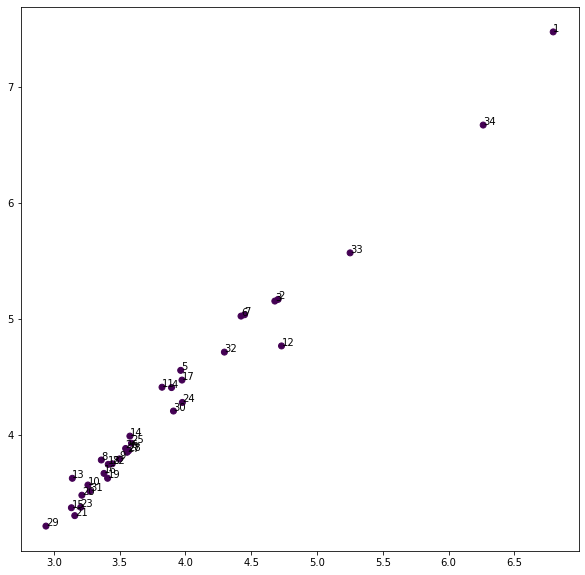

Cross Entropy Loss: = 0.6648465394973755


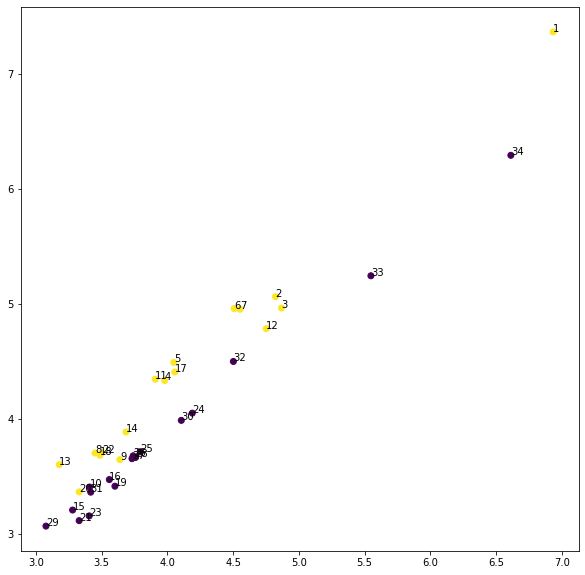

Cross Entropy Loss: = 0.5244415402412415


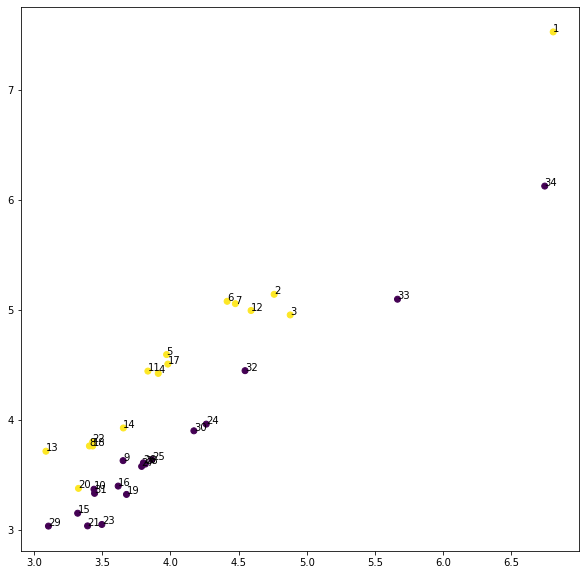

Cross Entropy Loss: = 0.41451573371887207


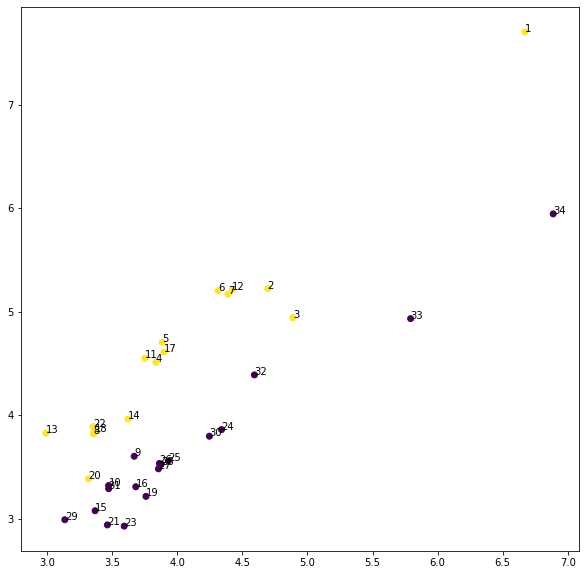

Cross Entropy Loss: = 0.31777119636535645


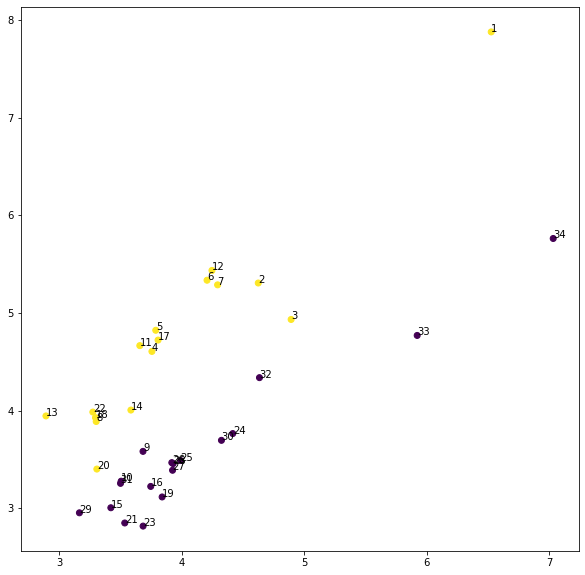

Cross Entropy Loss: = 0.2393493801355362


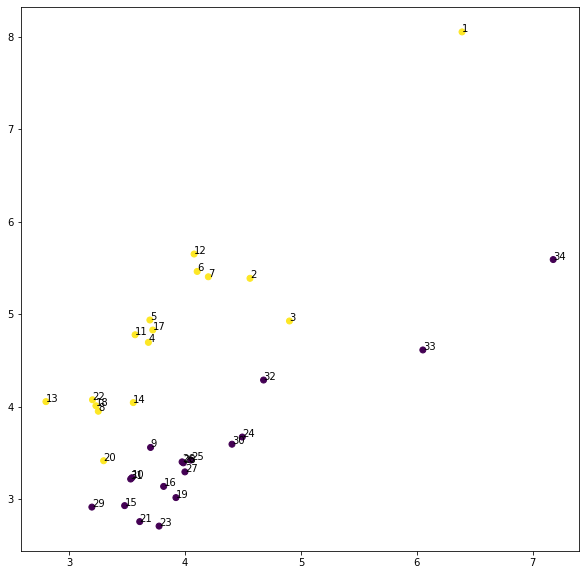

Cross Entropy Loss: = 0.18050517141819


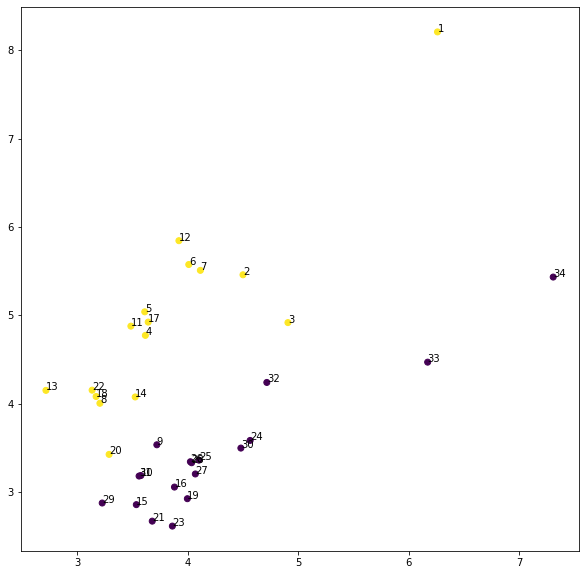

Cross Entropy Loss: = 0.13842535018920898


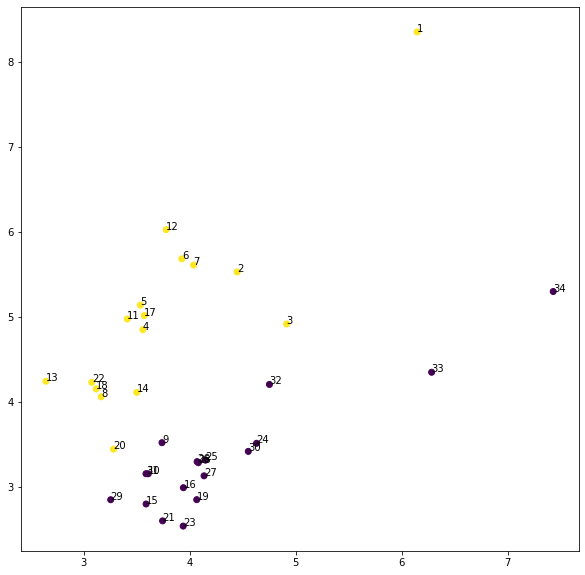

Cross Entropy Loss: = 0.10851722955703735


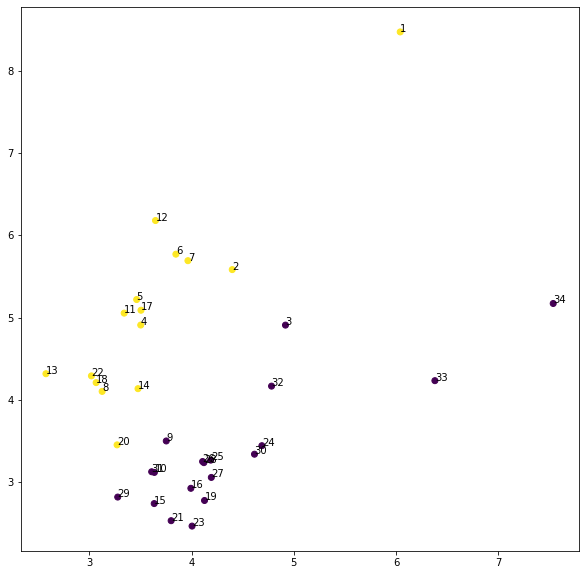

Cross Entropy Loss: = 0.0870833694934845


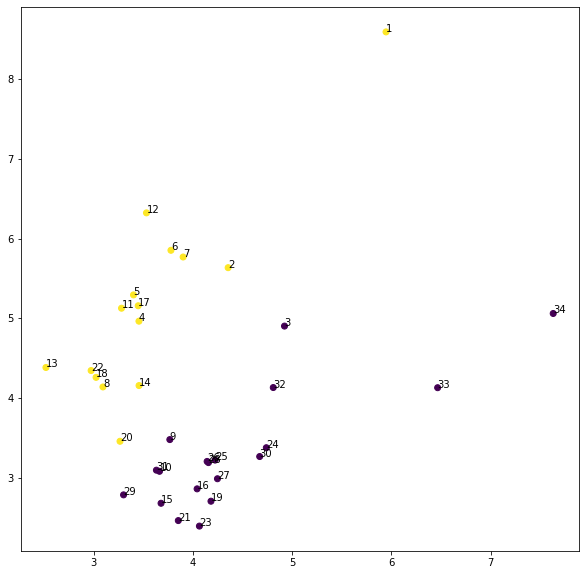

Cross Entropy Loss: = 0.071446493268013


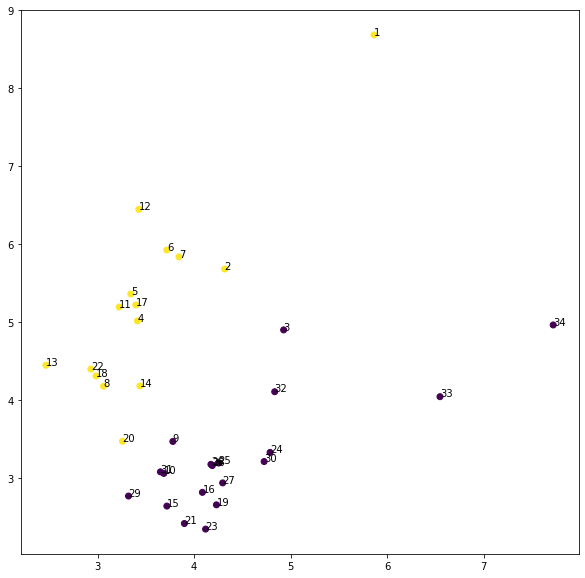

Cross Entropy Loss: = 0.0597710981965065


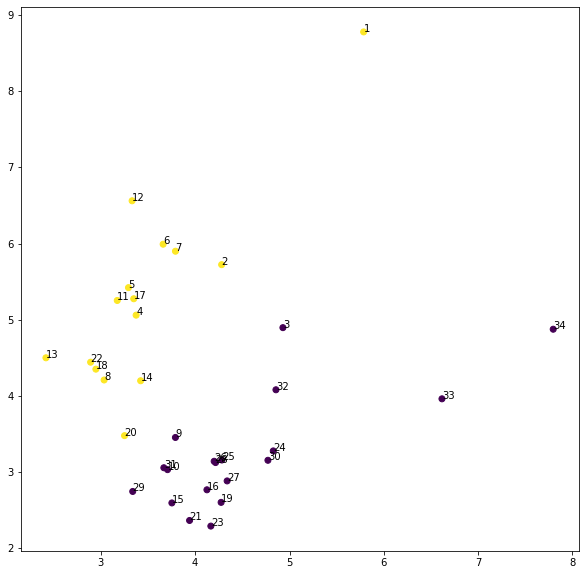

Cross Entropy Loss: = 0.05086018145084381


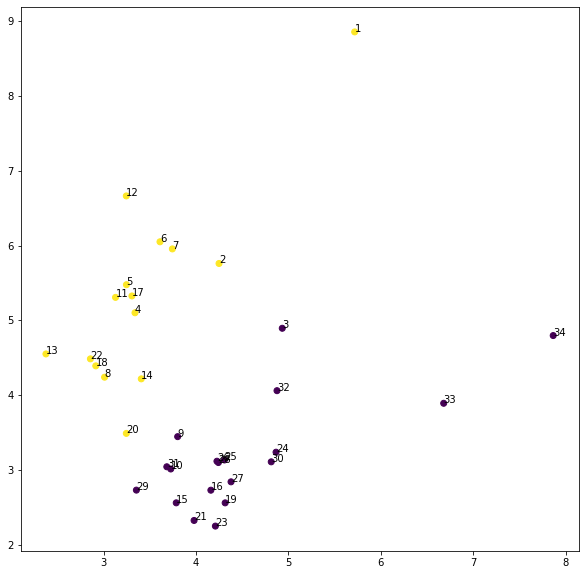

Cross Entropy Loss: = 0.043917082250118256


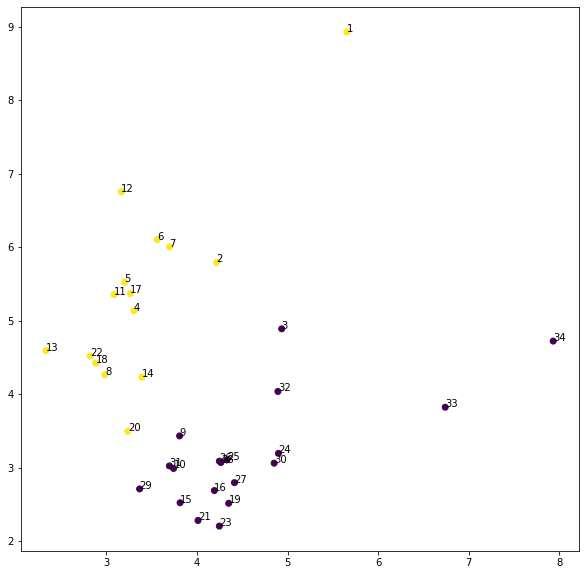

Cross Entropy Loss: = 0.03841734677553177


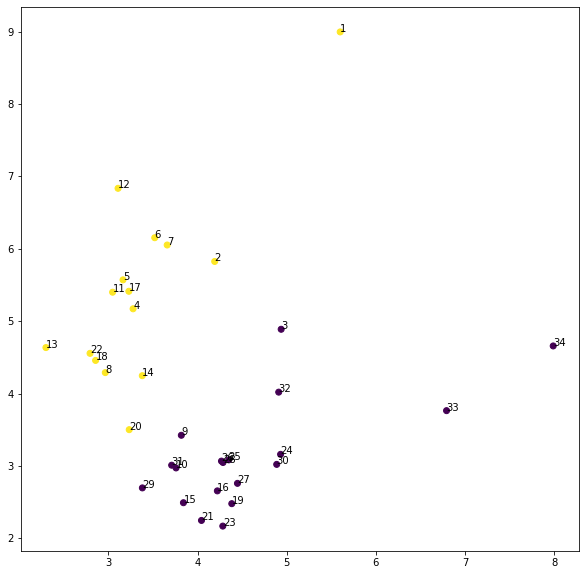

Cross Entropy Loss: = 0.034056156873703


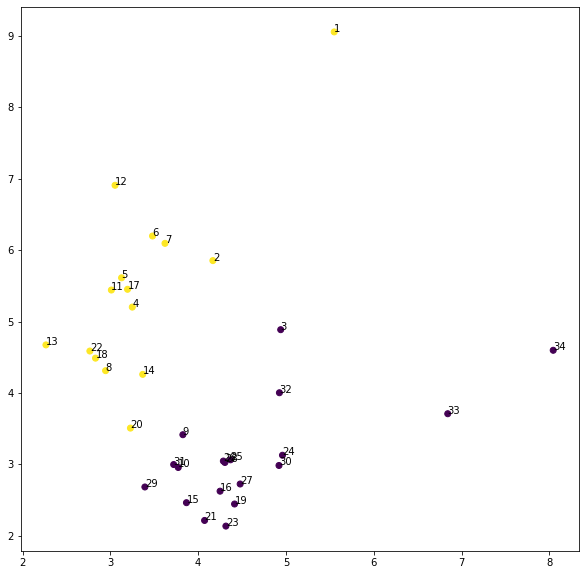

Cross Entropy Loss: = 0.030466172844171524


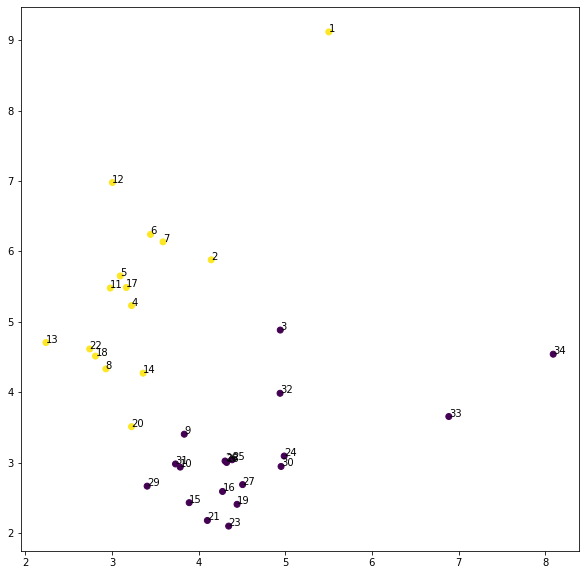

Cross Entropy Loss: = 0.02747228555381298


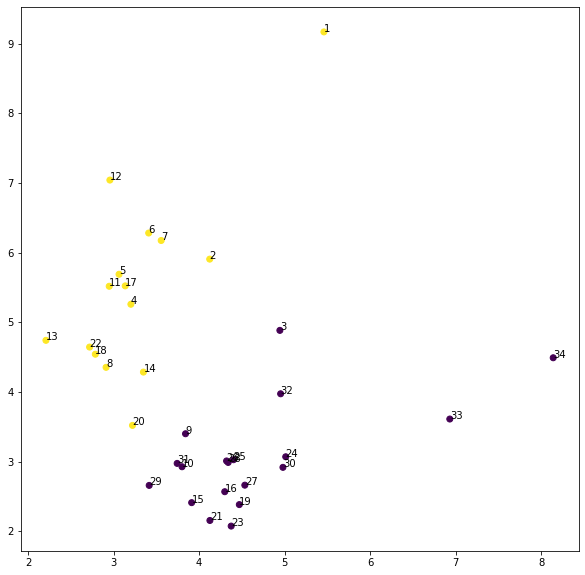

Cross Entropy Loss: = 0.02494662255048752


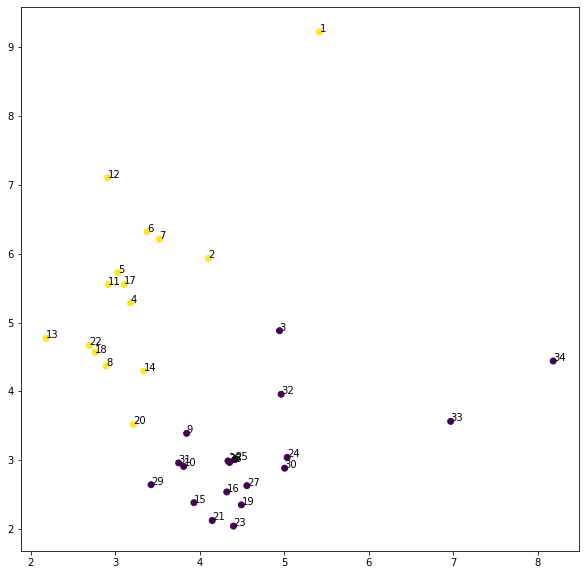

Cross Entropy Loss: = 0.0227937251329422


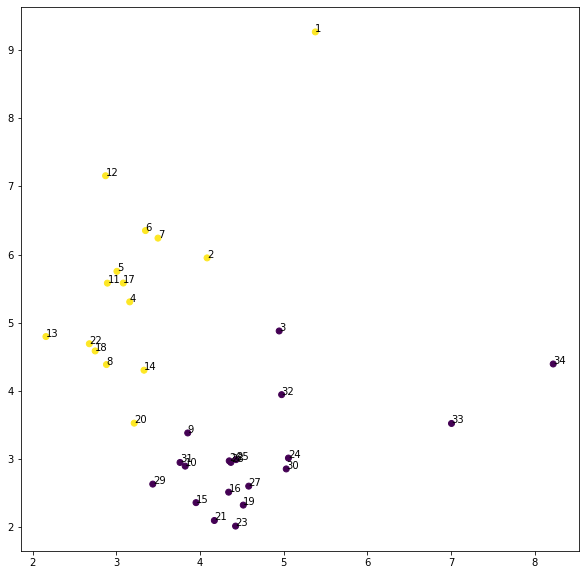

Cross Entropy Loss: = 0.02094155177474022


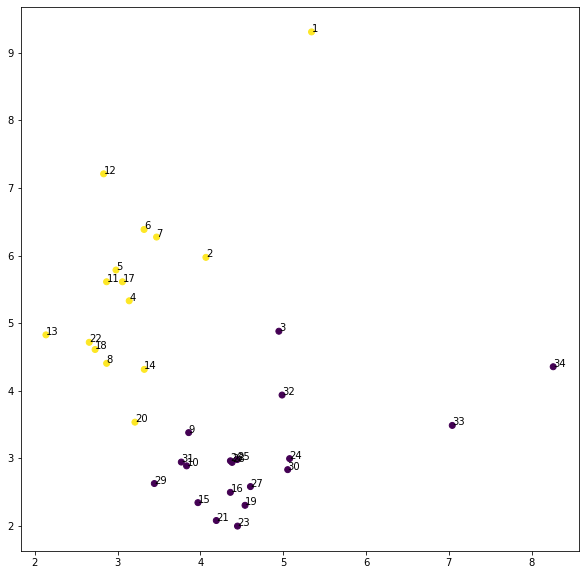

Cross Entropy Loss: = 0.019335074350237846


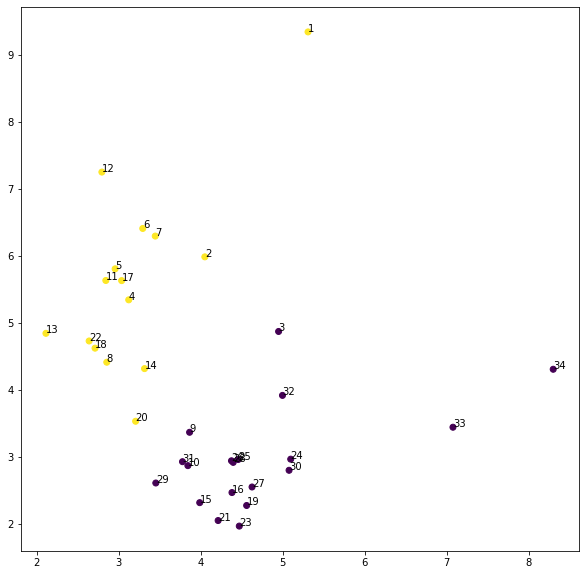

Cross Entropy Loss: = 0.017932752147316933


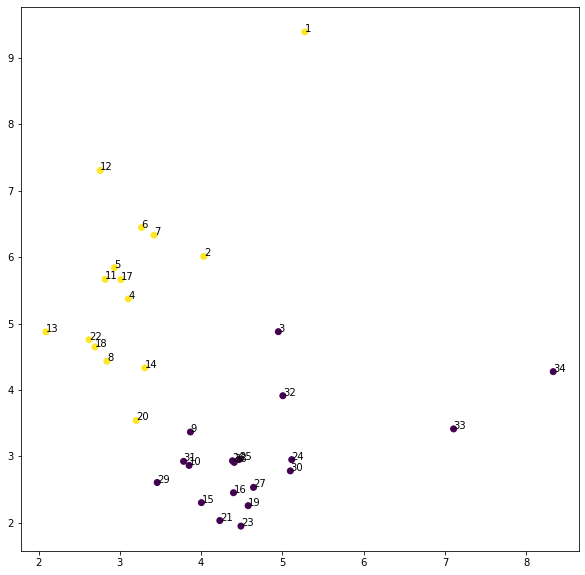

Cross Entropy Loss: = 0.016698341816663742


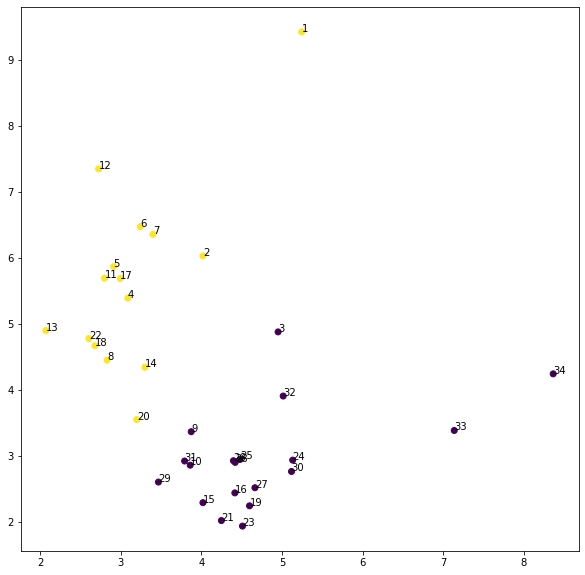

Cross Entropy Loss: = 0.015604894608259201


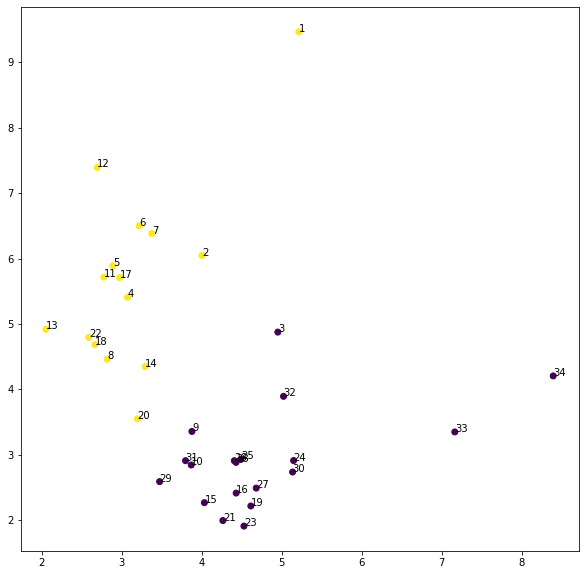

Cross Entropy Loss: = 0.014630845747888088


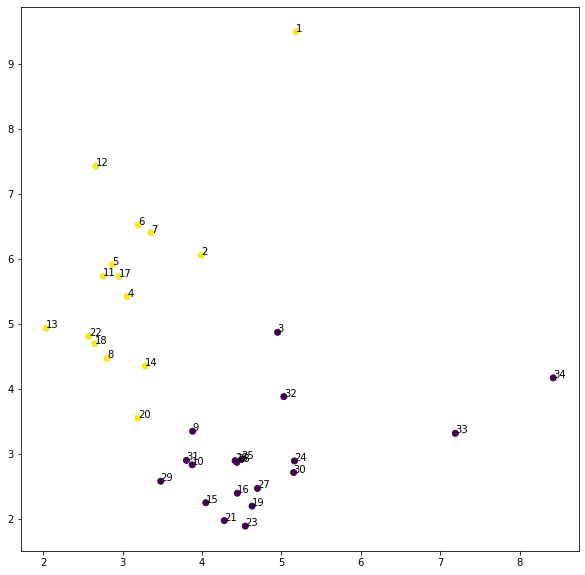

Cross Entropy Loss: = 0.013758674263954163


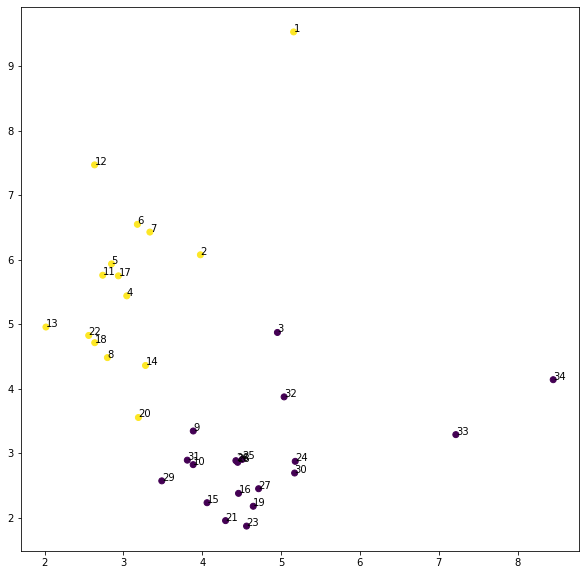

Cross Entropy Loss: = 0.012973996810615063


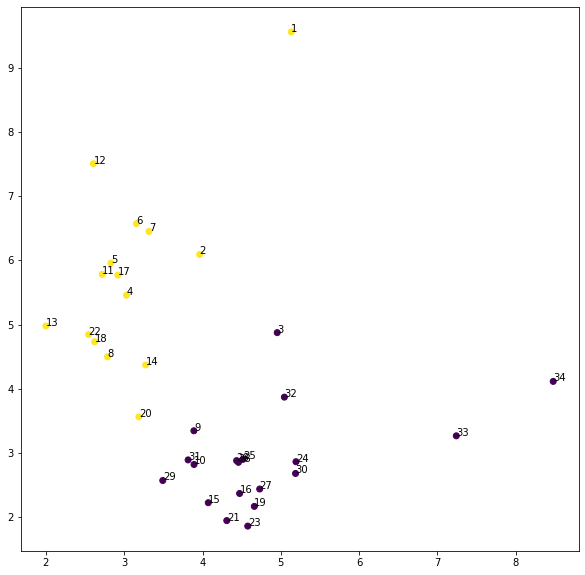

Cross Entropy Loss: = 0.012267248705029488


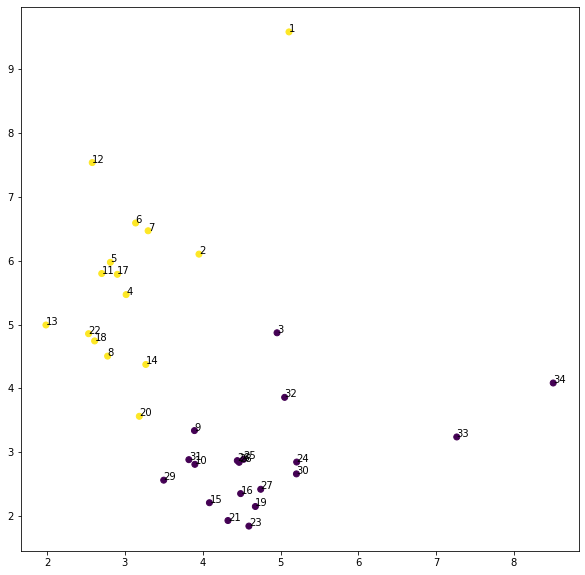

Cross Entropy Loss: = 0.01162728201597929


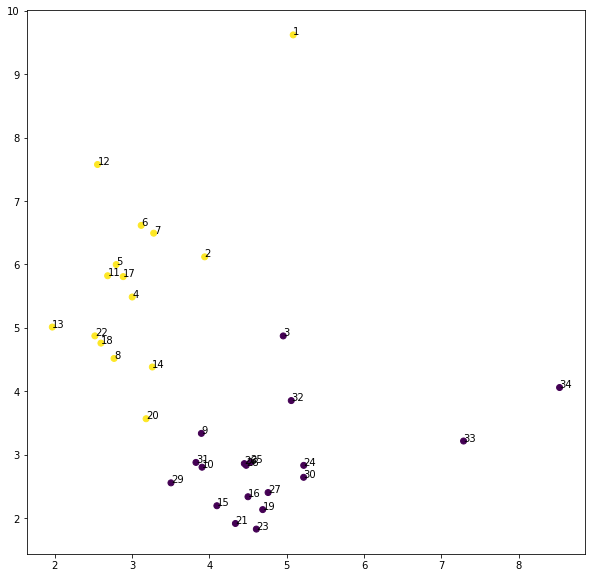

Cross Entropy Loss: = 0.011044030077755451


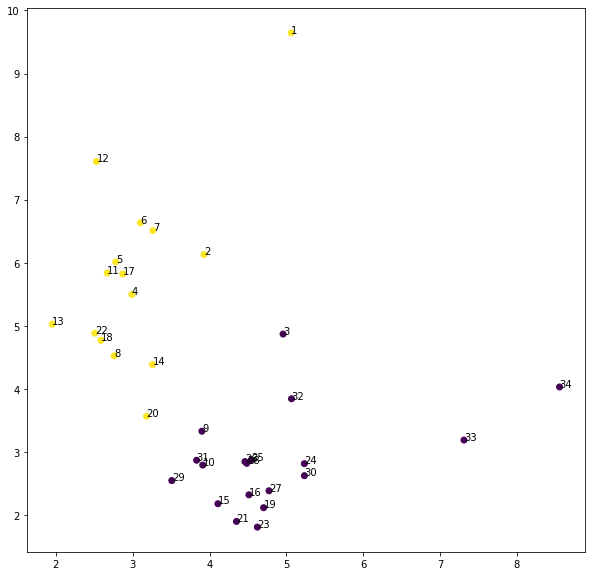

Cross Entropy Loss: = 0.01051074918359518


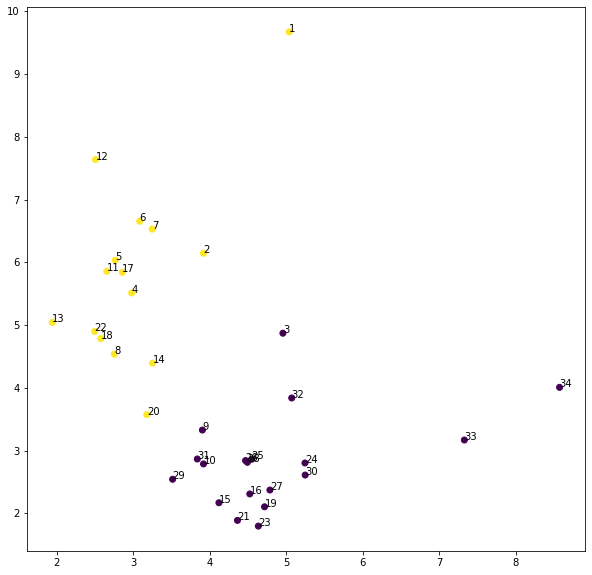

Cross Entropy Loss: = 0.01002150122076273


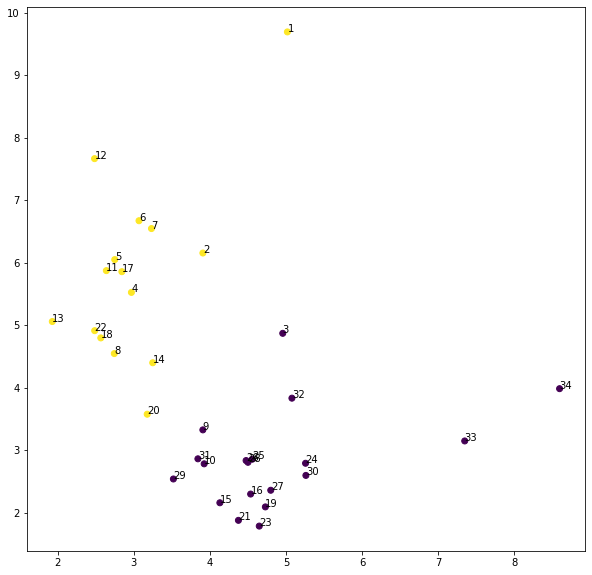

Cross Entropy Loss: = 0.009571332484483719


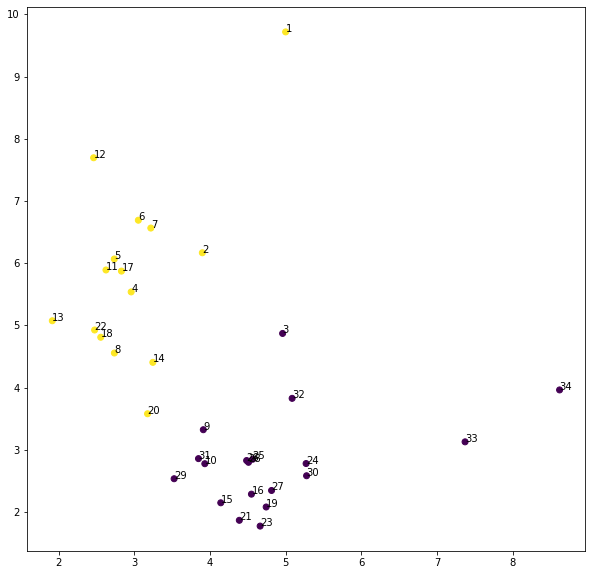

Cross Entropy Loss: = 0.00915592536330223


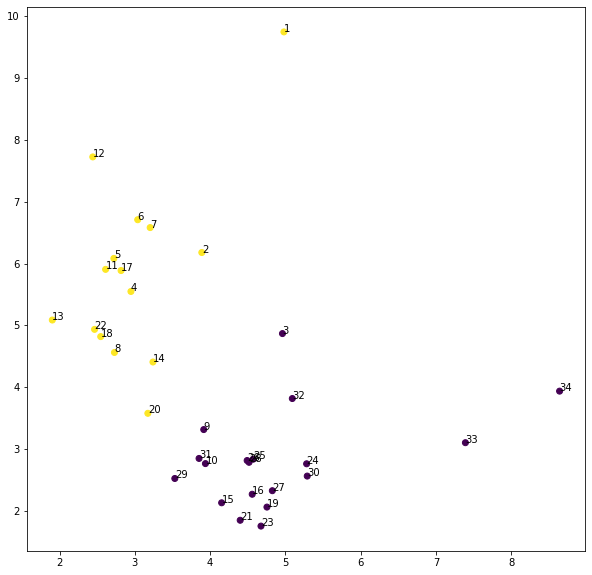

Cross Entropy Loss: = 0.008771601133048534


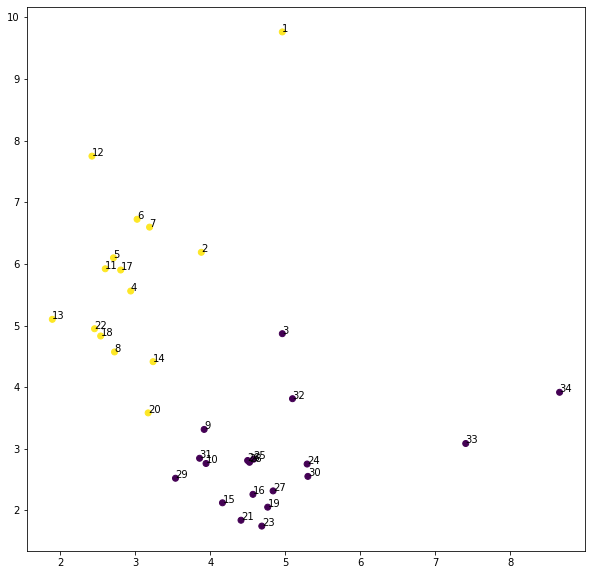

Cross Entropy Loss: = 0.008415145799517632


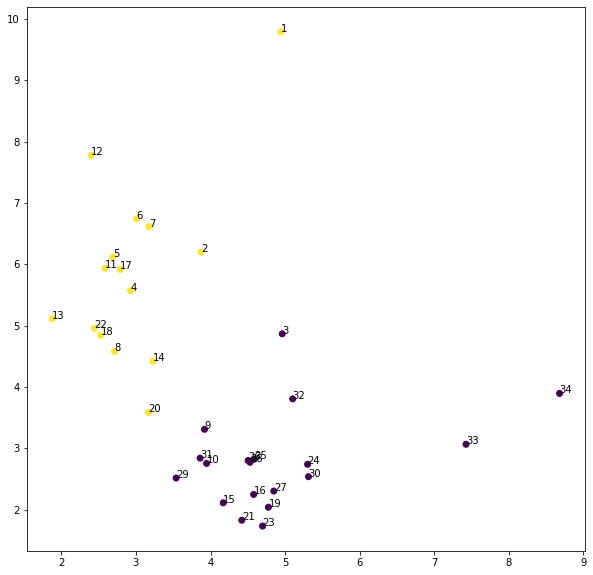

Cross Entropy Loss: = 0.008083809167146683


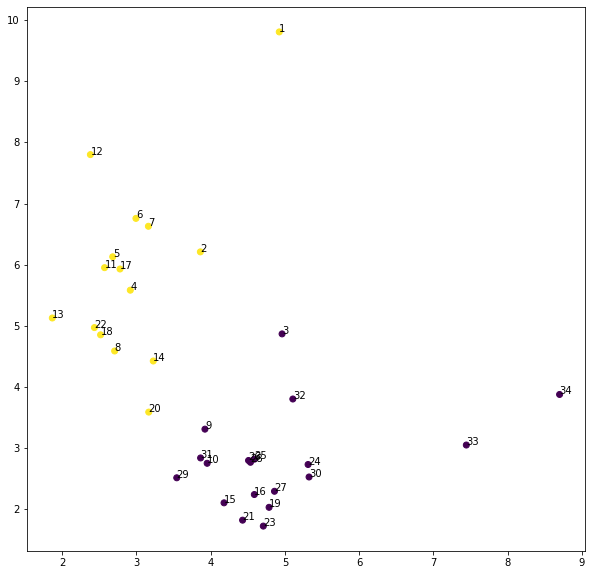

Cross Entropy Loss: = 0.007775073871016502


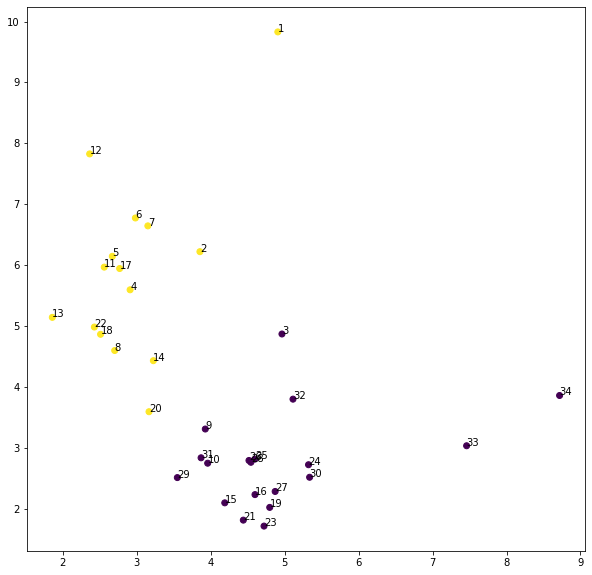

Cross Entropy Loss: = 0.007486829999834299


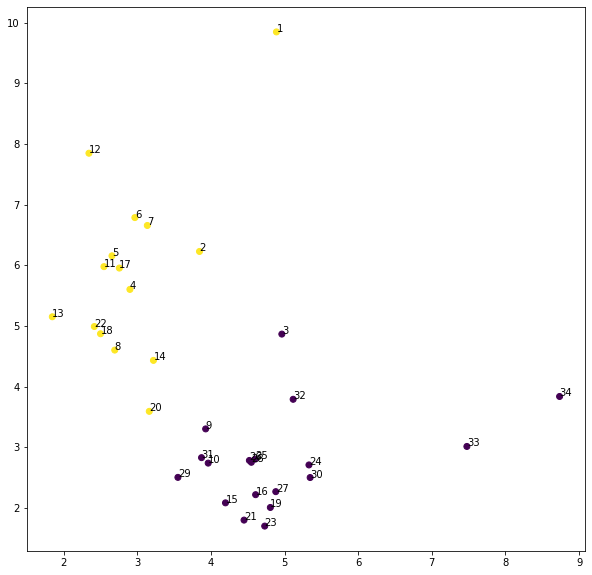

Cross Entropy Loss: = 0.007217203266918659


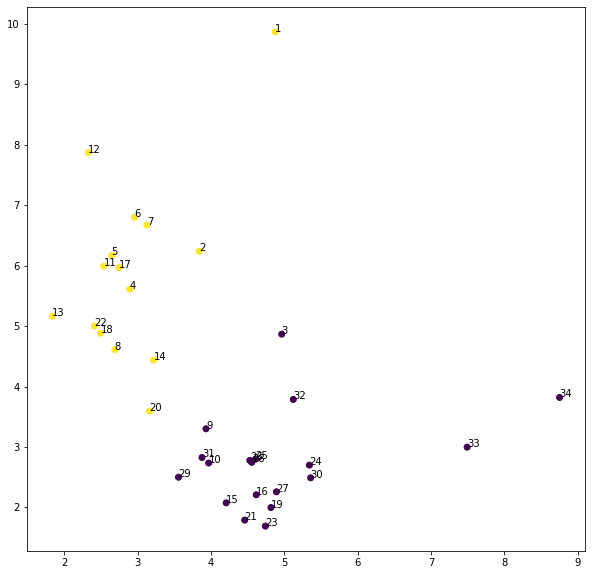

Cross Entropy Loss: = 0.006964491680264473


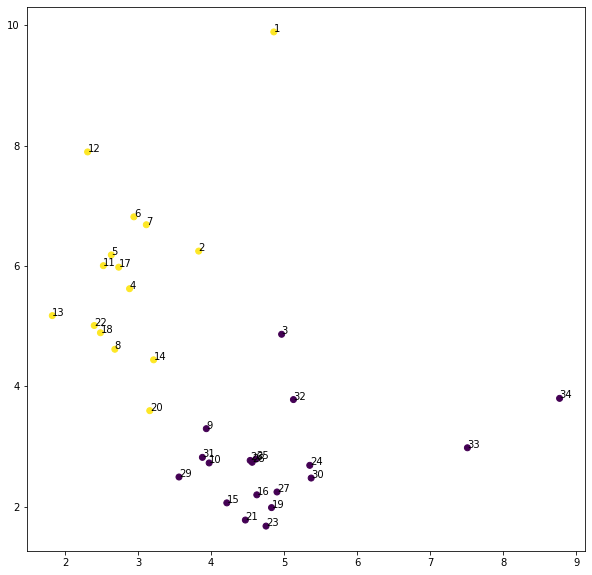

Cross Entropy Loss: = 0.006727286614477634


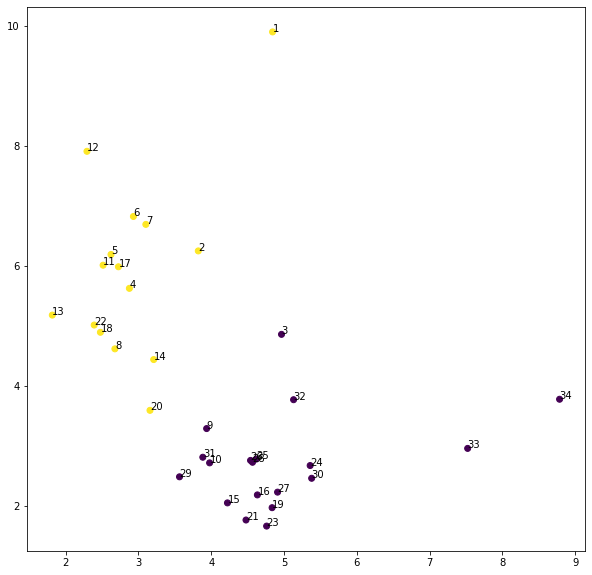

Cross Entropy Loss: = 0.006504178512841463


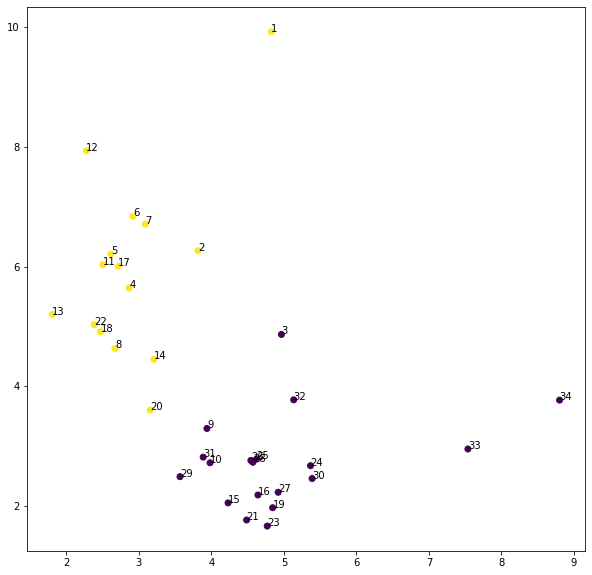

Cross Entropy Loss: = 0.00629405165091157


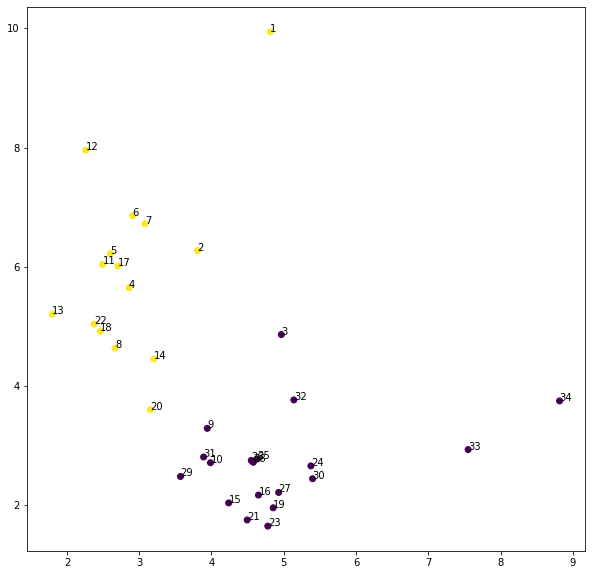

Cross Entropy Loss: = 0.006095788441598415


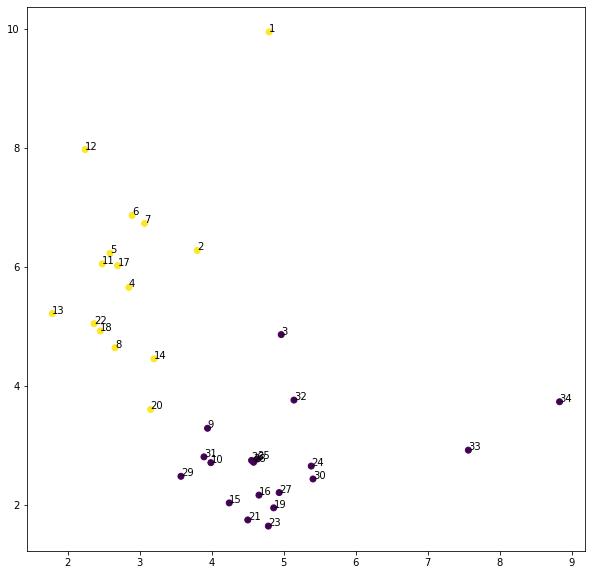

Cross Entropy Loss: = 0.00590856559574604


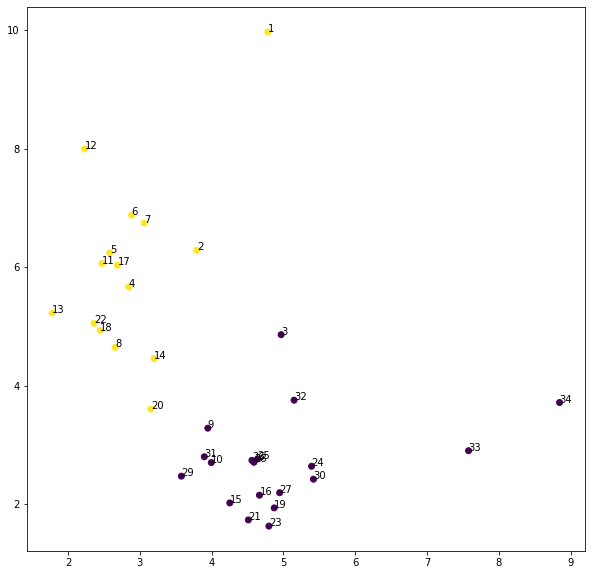

Cross Entropy Loss: = 0.005731442477554083


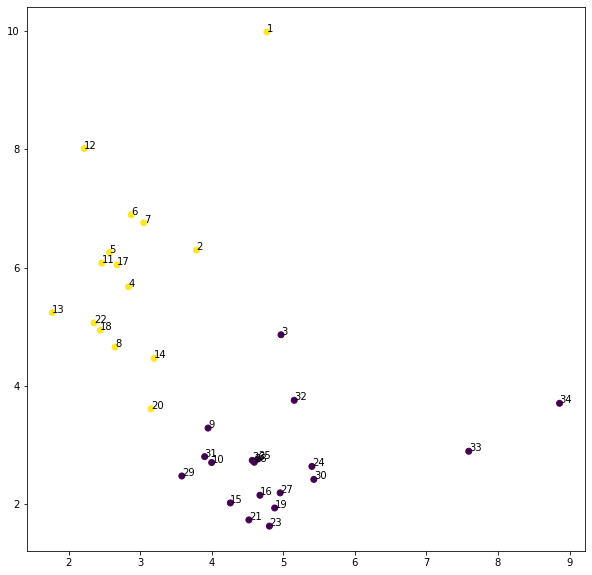

Cross Entropy Loss: = 0.005564660765230656


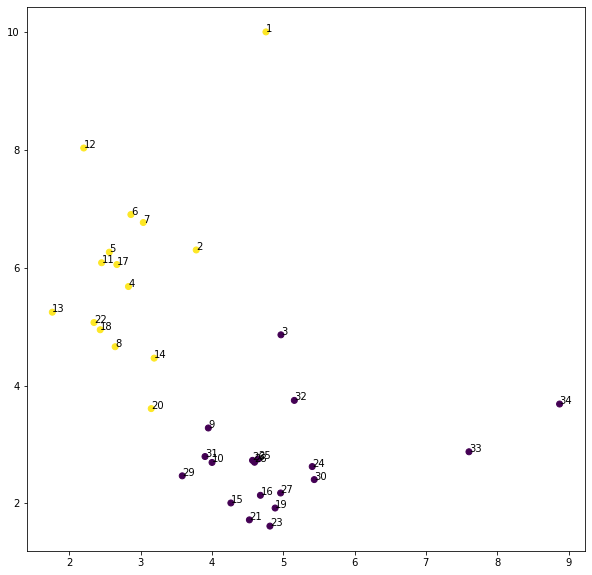

Cross Entropy Loss: = 0.005406625103205442


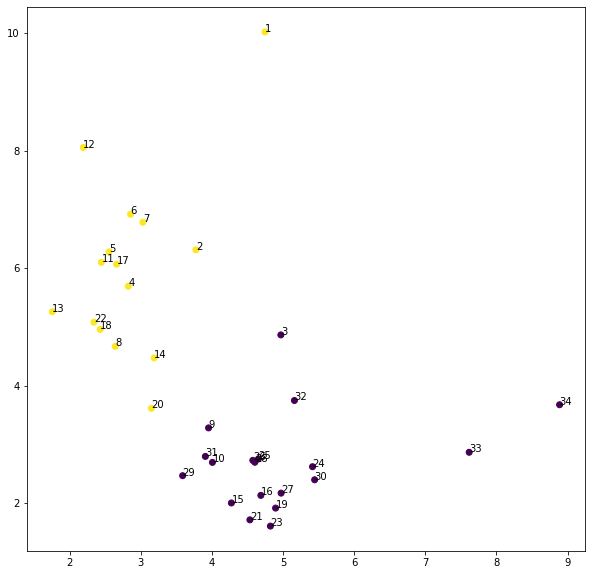

Cross Entropy Loss: = 0.005256627686321735


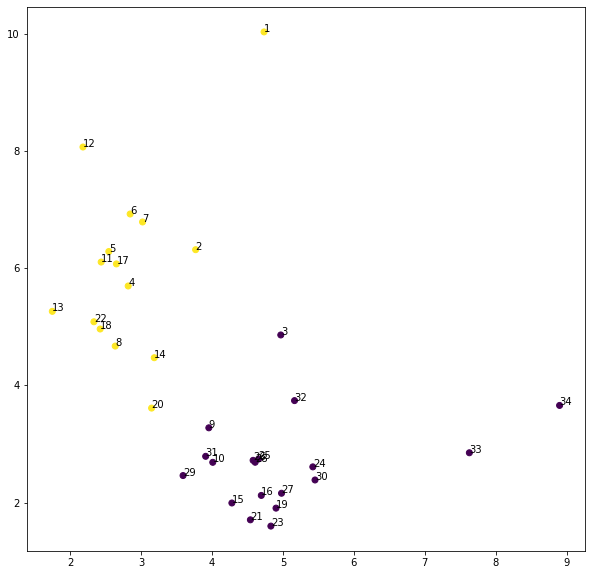

Cross Entropy Loss: = 0.005113961640745401


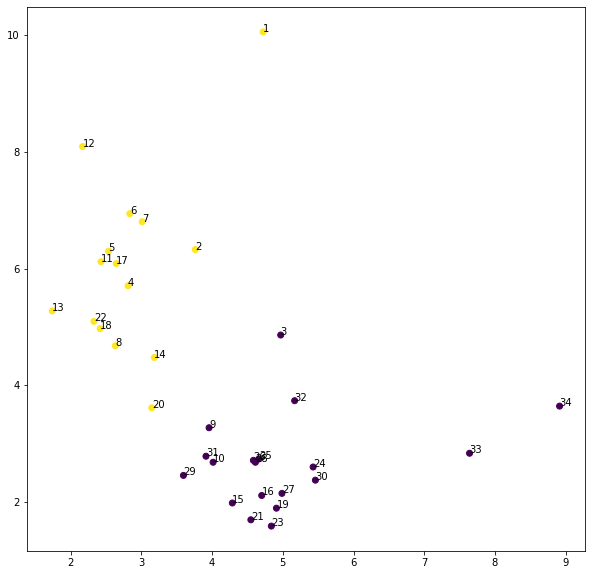

Cross Entropy Loss: = 0.004978095181286335


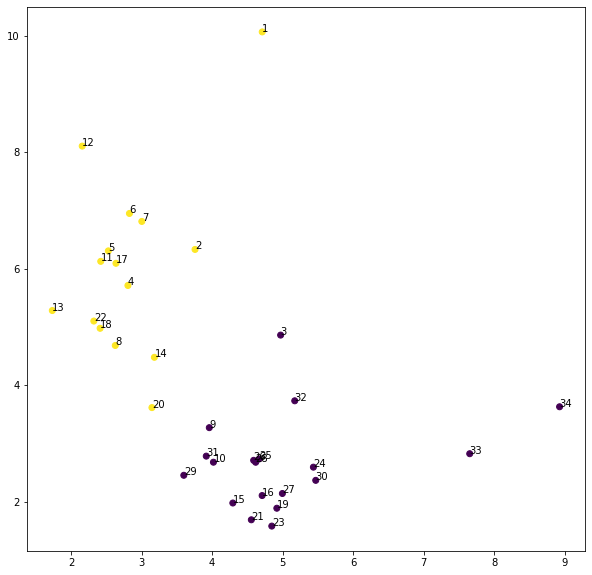

Cross Entropy Loss: = 0.0048486762680113316


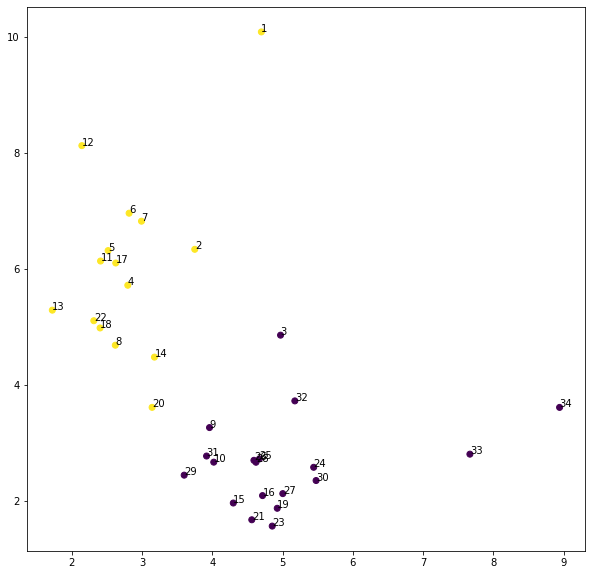

Cross Entropy Loss: = 0.004725172650068998


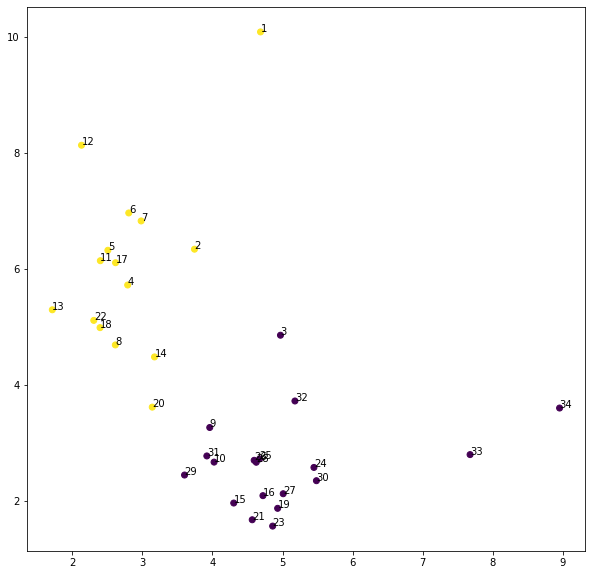

Cross Entropy Loss: = 0.004607290029525757


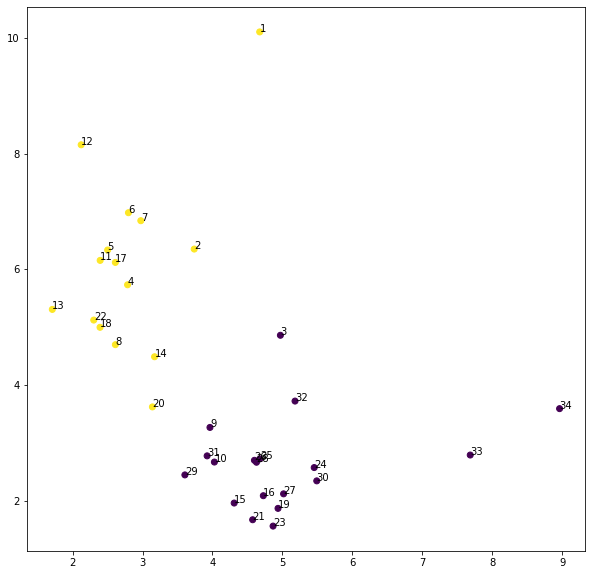

Cross Entropy Loss: = 0.004494614899158478


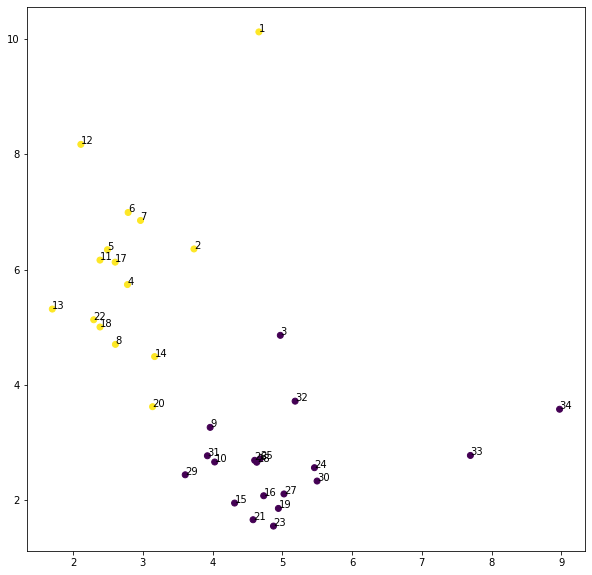

Cross Entropy Loss: = 0.004386912565678358


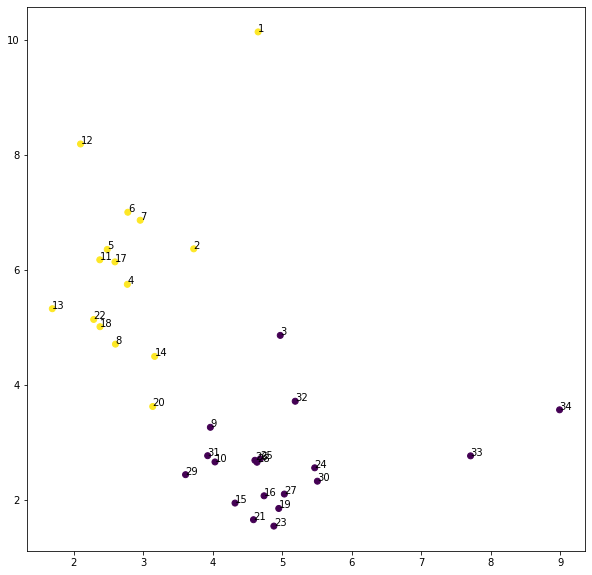

Cross Entropy Loss: = 0.0042837089858949184


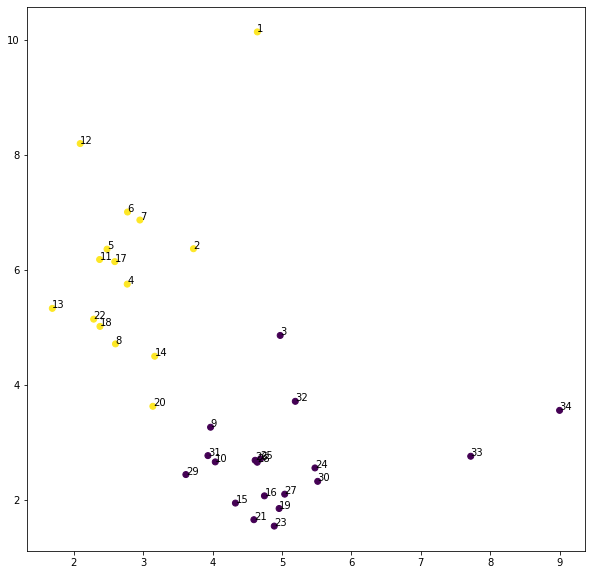

Cross Entropy Loss: = 0.004184886813163757


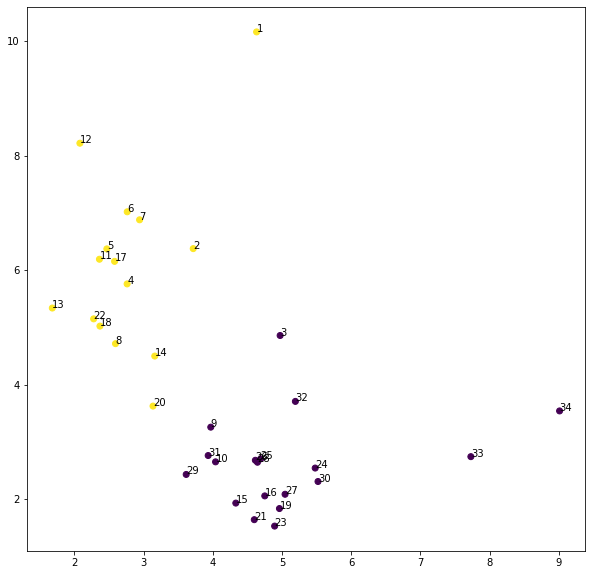

Cross Entropy Loss: = 0.0040900916792452335


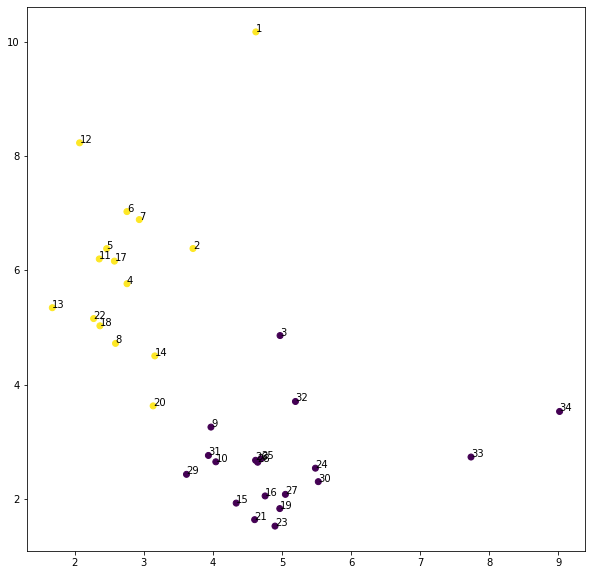

Cross Entropy Loss: = 0.003999146167188883


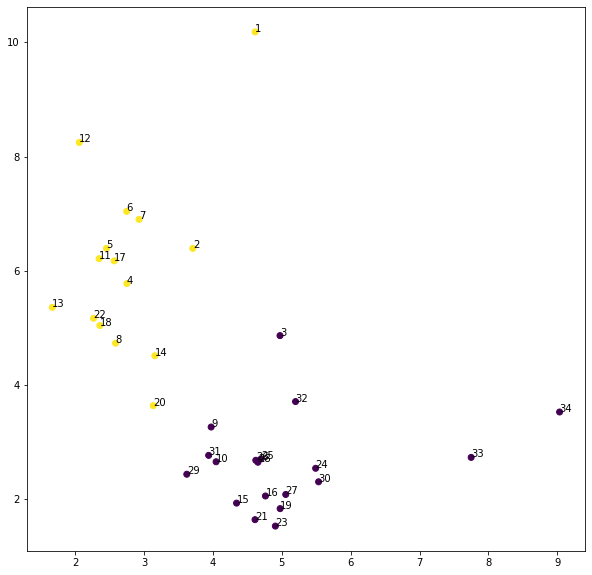

Cross Entropy Loss: = 0.00391181418672204


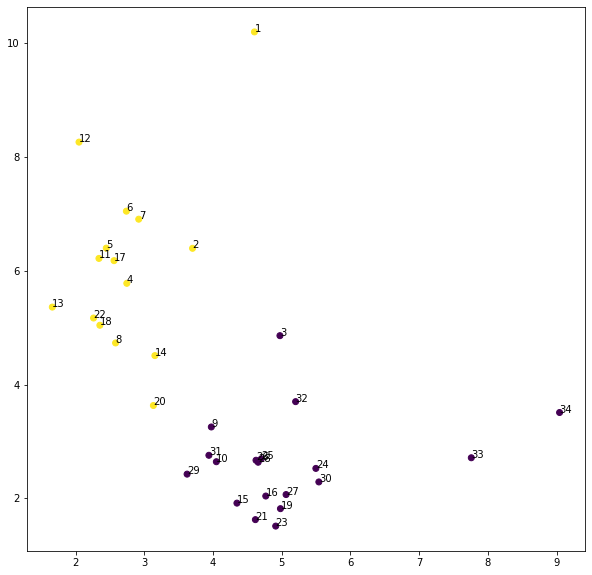

Cross Entropy Loss: = 0.003827918553724885


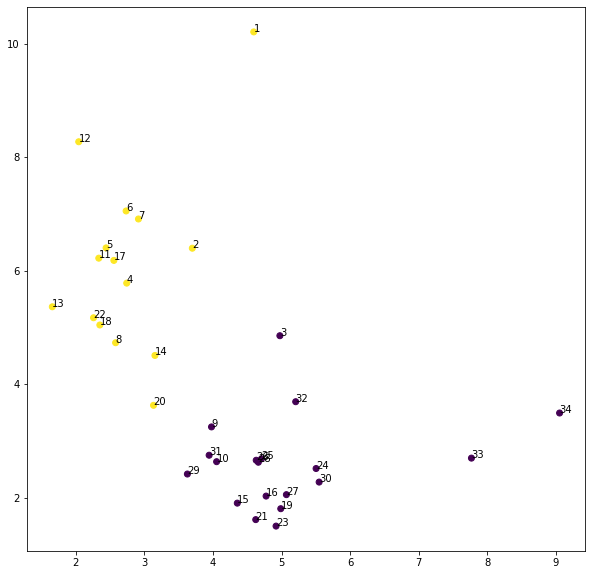

Cross Entropy Loss: = 0.003747162874788046


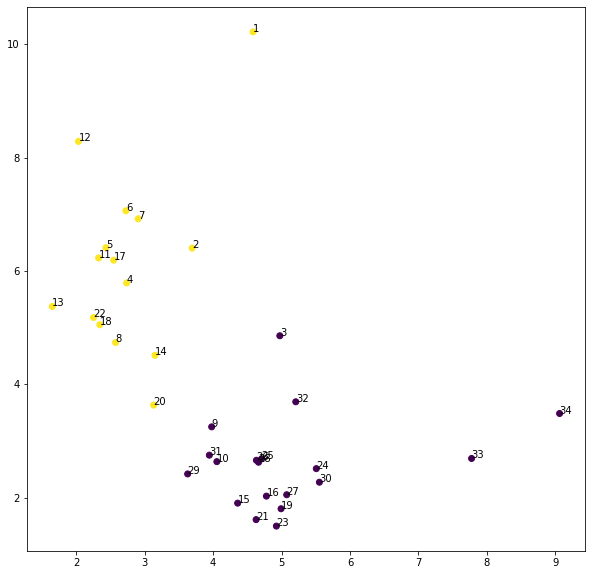

Cross Entropy Loss: = 0.003669548314064741


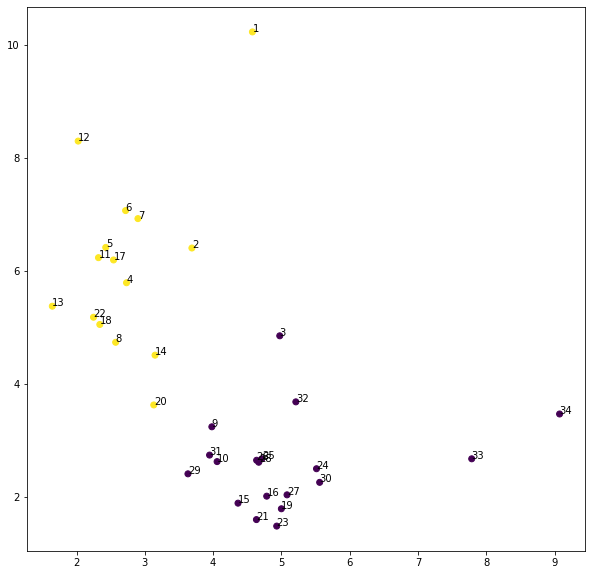

Cross Entropy Loss: = 0.0035947784781455994


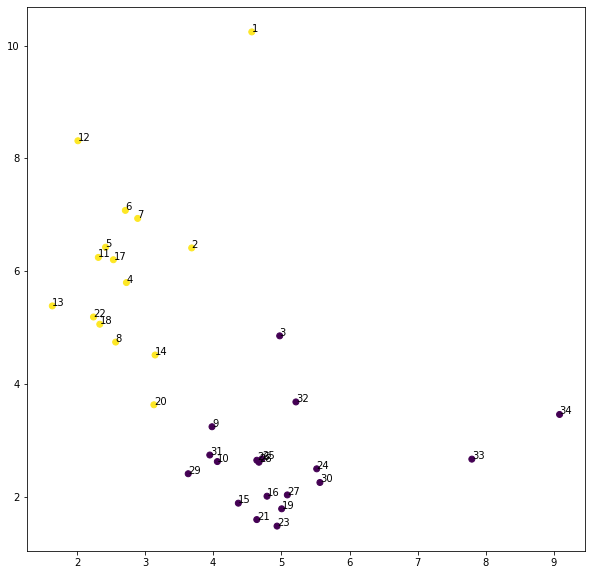

Cross Entropy Loss: = 0.0035227350890636444


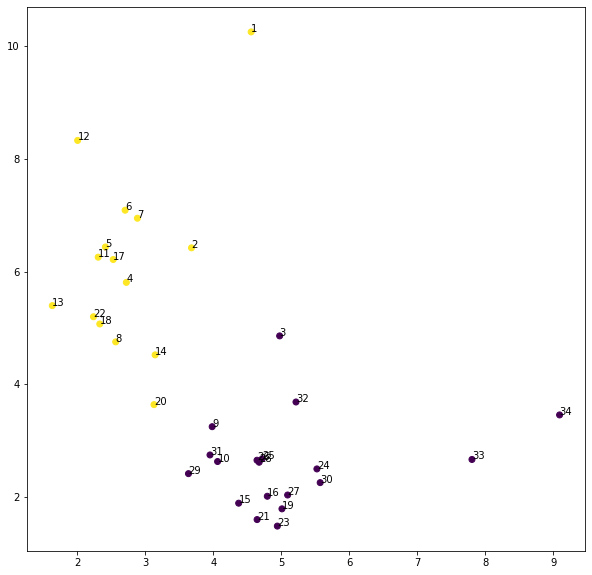

Cross Entropy Loss: = 0.003453240729868412


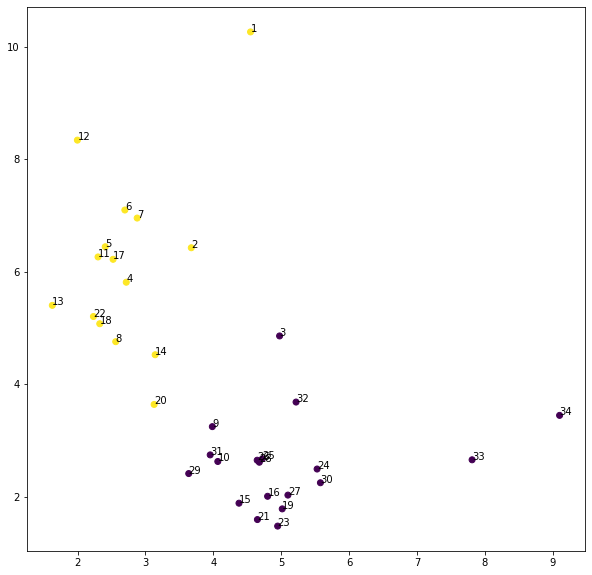

Cross Entropy Loss: = 0.003386236261576414


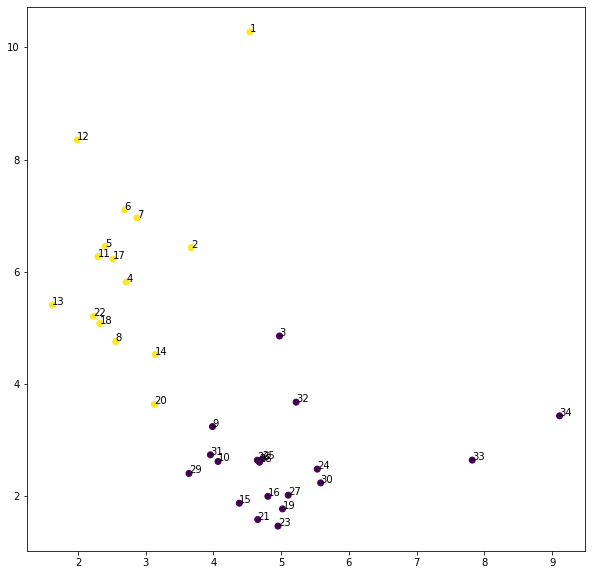

Cross Entropy Loss: = 0.0033215442672371864


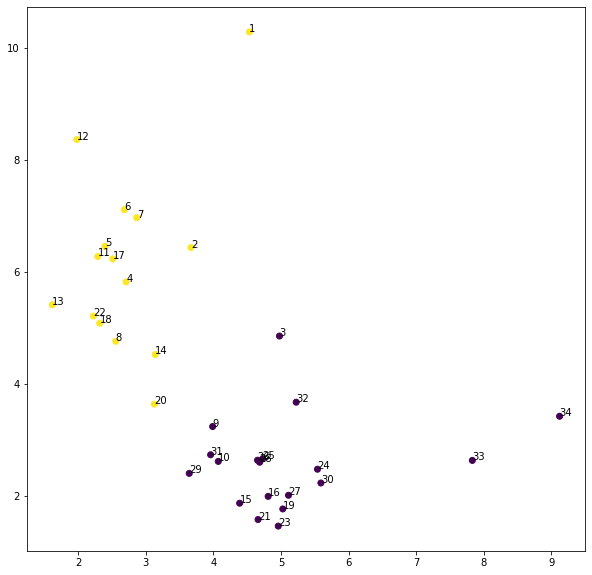

Cross Entropy Loss: = 0.0032591652125120163


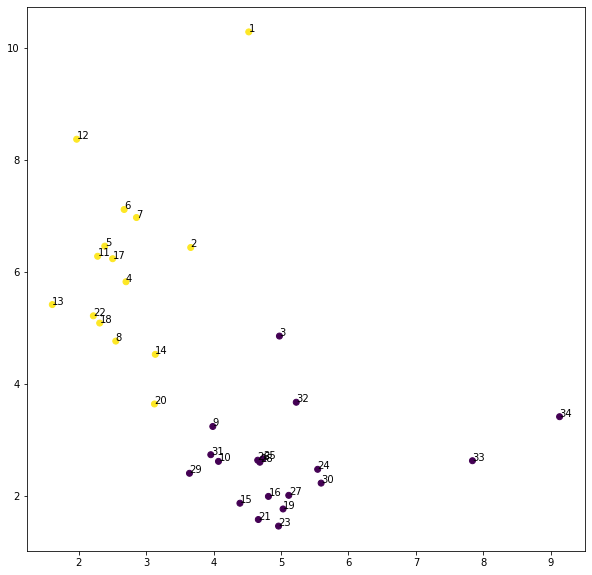

Cross Entropy Loss: = 0.003198802238330245


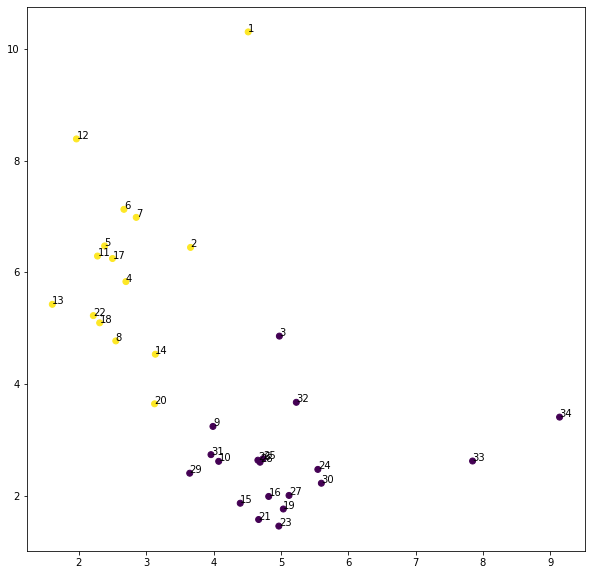

Cross Entropy Loss: = 0.0031404560431838036


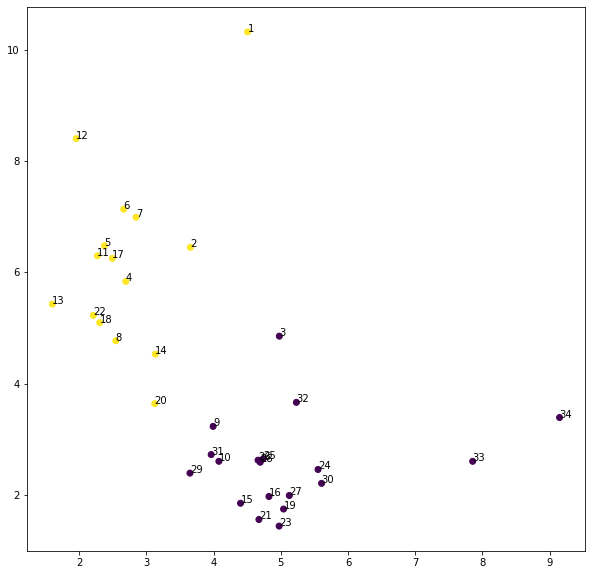

Cross Entropy Loss: = 0.0030840670224279165


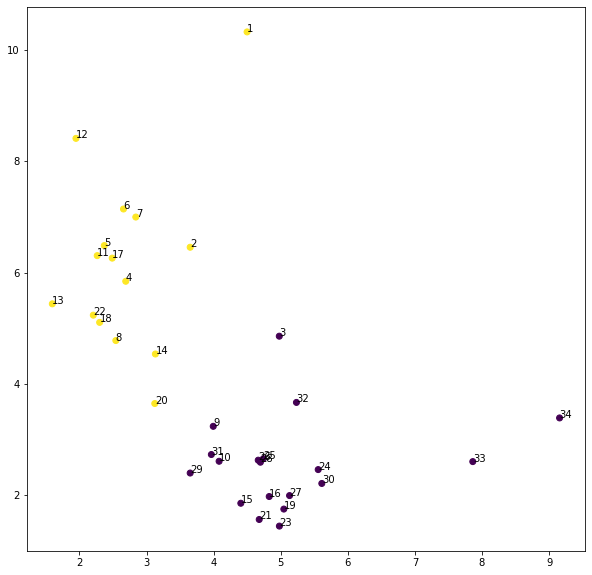

Cross Entropy Loss: = 0.0030294577591121197


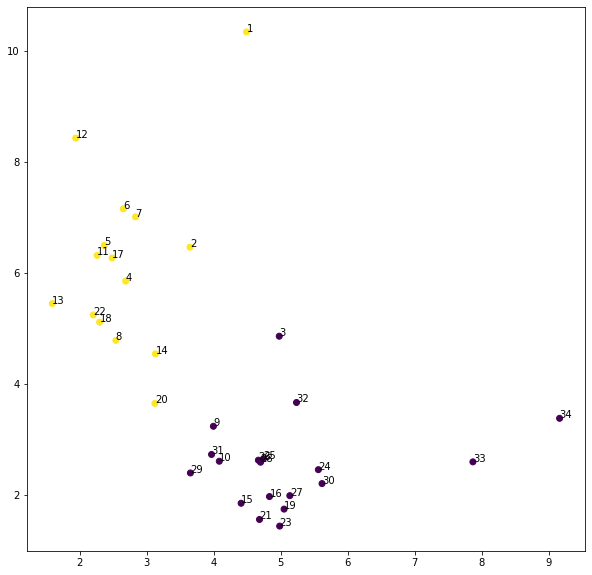

Cross Entropy Loss: = 0.0029765688814222813


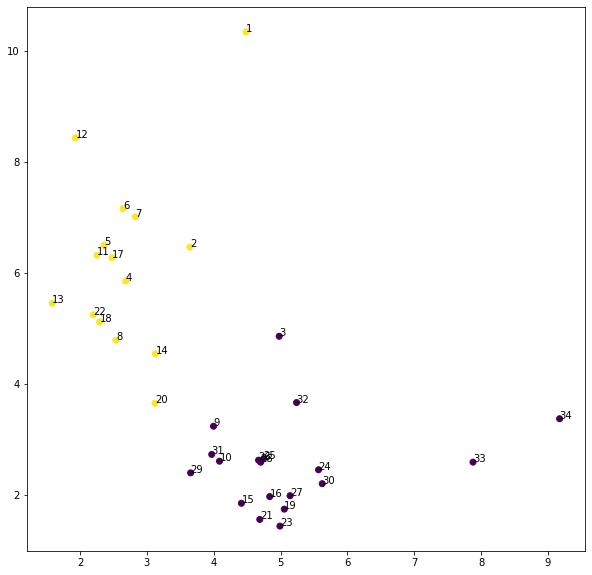

Cross Entropy Loss: = 0.002925400622189045


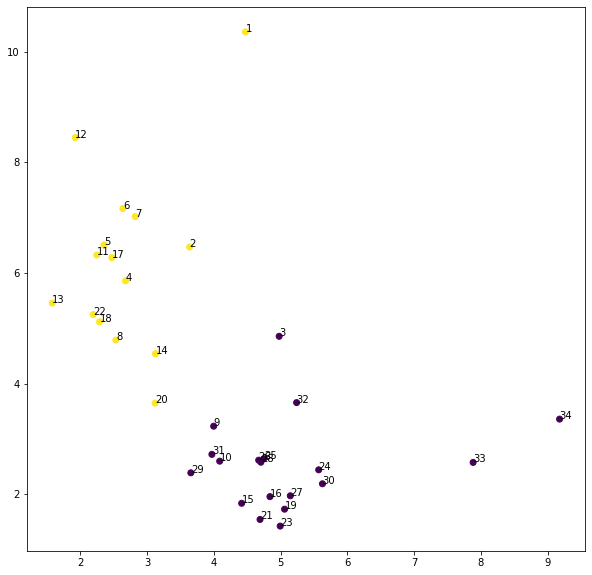

Cross Entropy Loss: = 0.002875775098800659


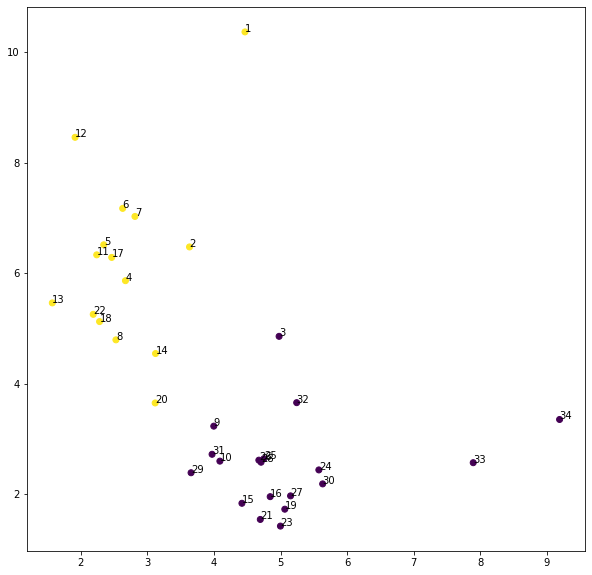

Cross Entropy Loss: = 0.0028277516830712557


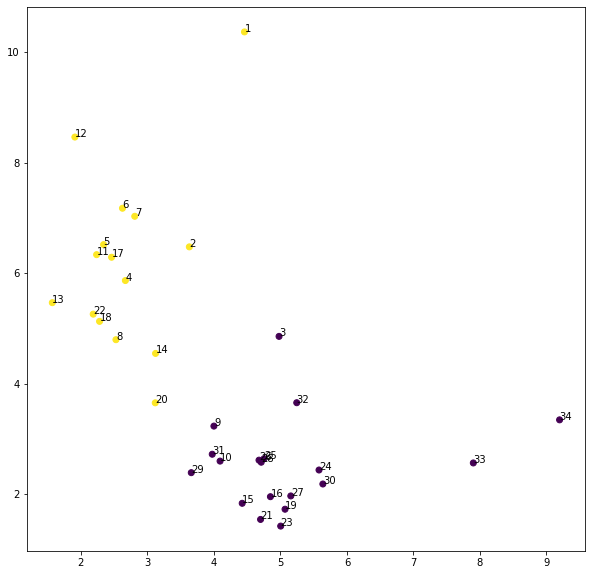

Cross Entropy Loss: = 0.002781093120574951


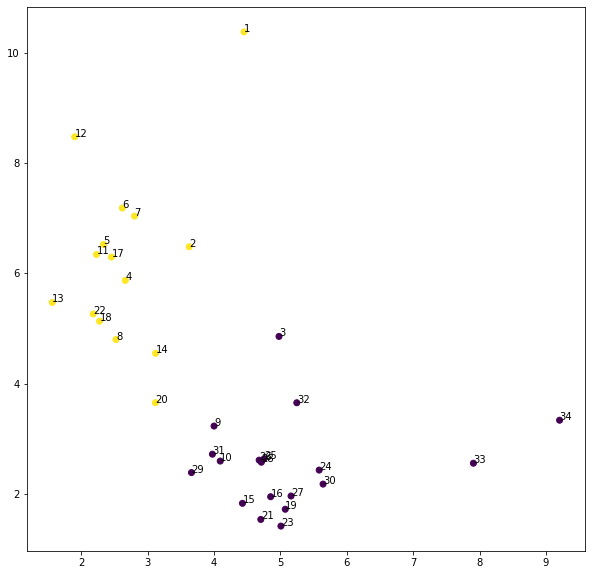

Cross Entropy Loss: = 0.0027357996441423893


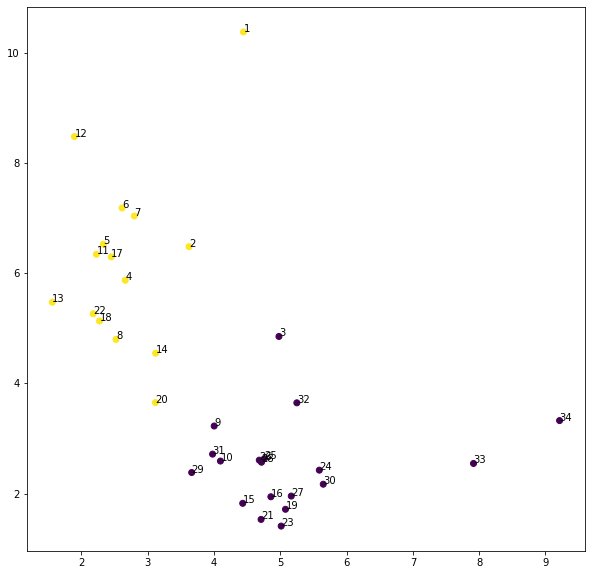

Cross Entropy Loss: = 0.002691930625587702


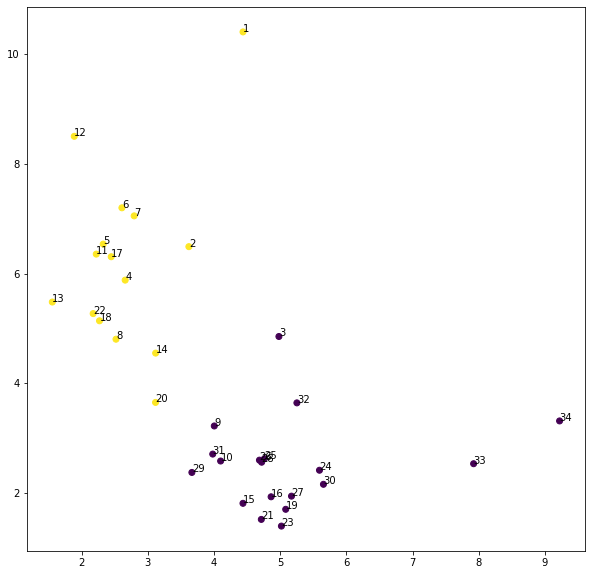

Cross Entropy Loss: = 0.0026492488104850054


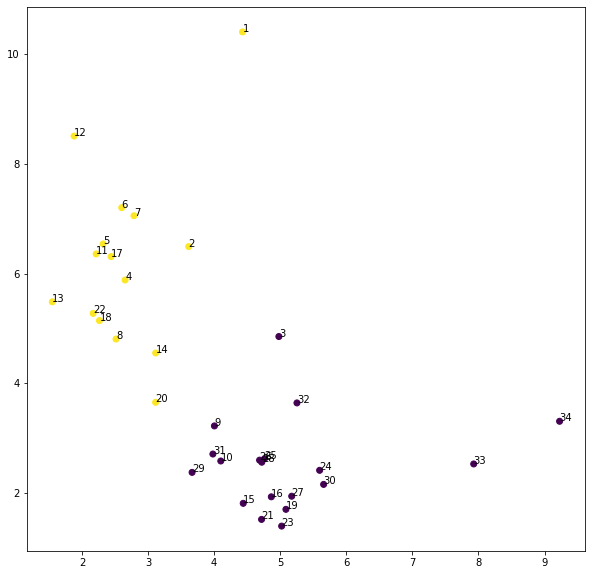

Cross Entropy Loss: = 0.002607873175293207


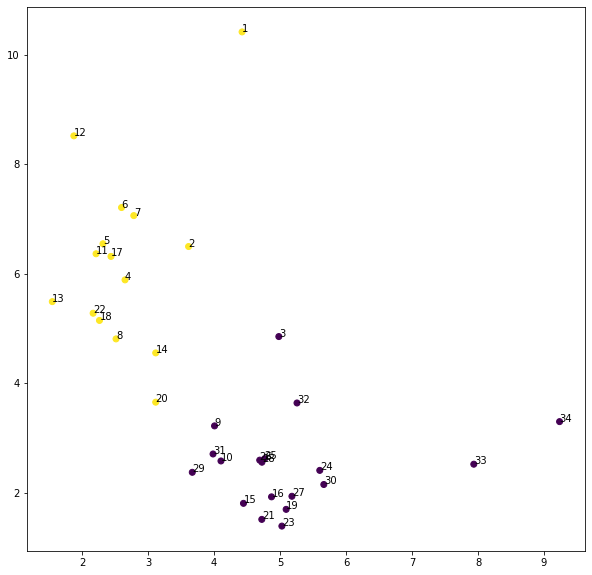

Cross Entropy Loss: = 0.0025675655342638493


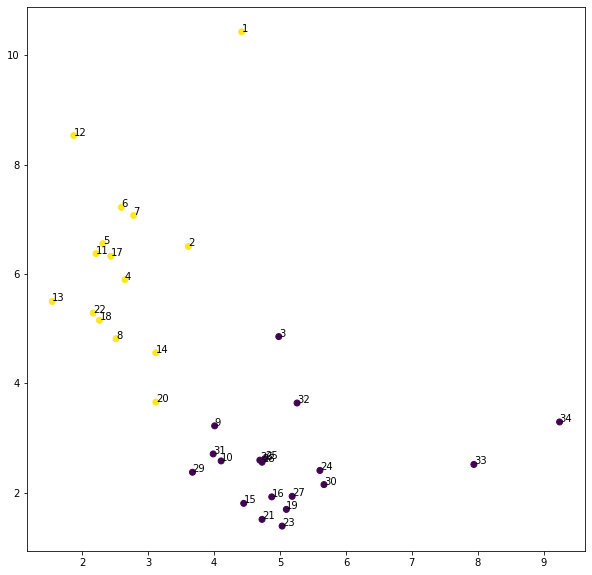

Cross Entropy Loss: = 0.0025284457951784134


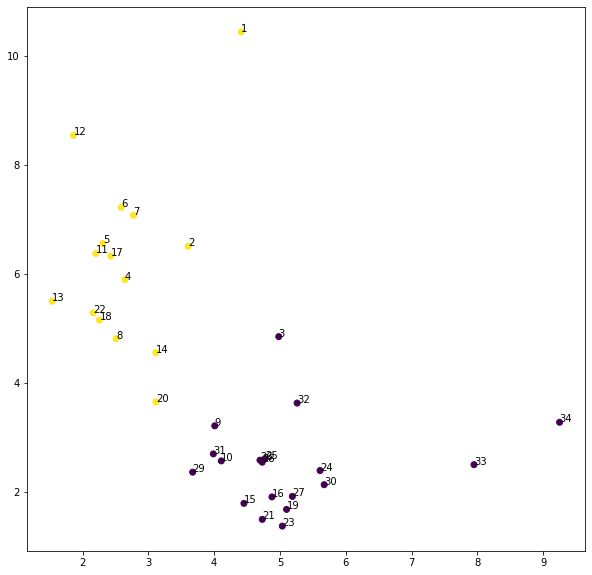

Cross Entropy Loss: = 0.0024903942830860615


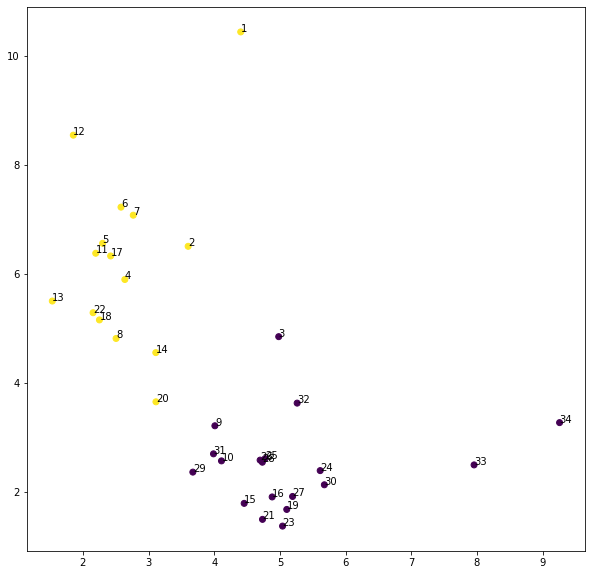

Cross Entropy Loss: = 0.0024533523246645927


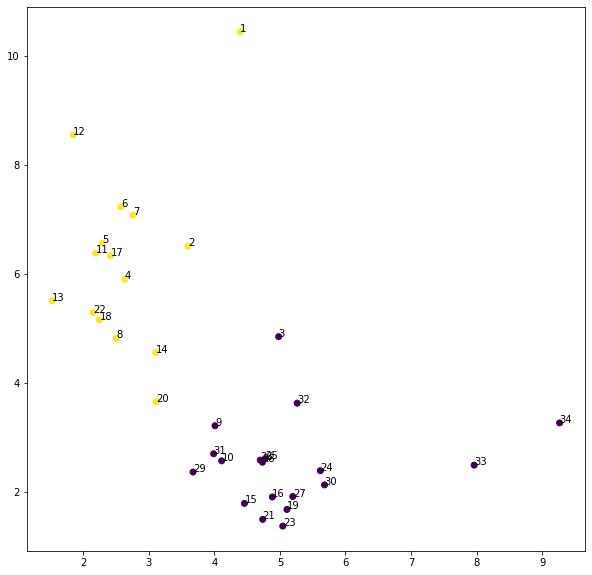

Cross Entropy Loss: = 0.0024173795245587826


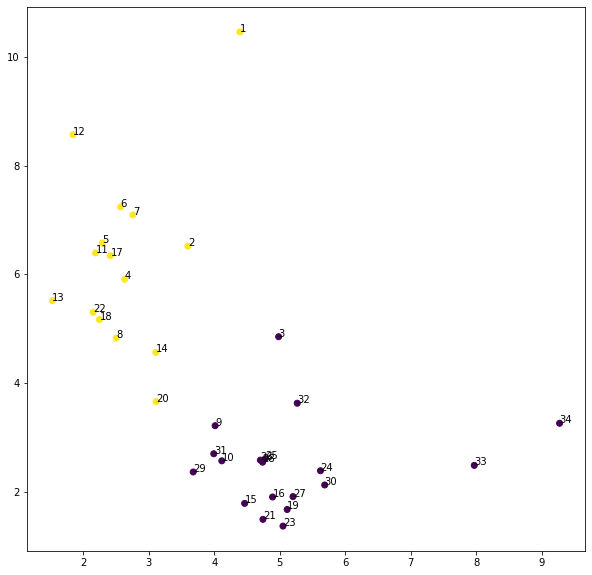

Cross Entropy Loss: = 0.002382297068834305


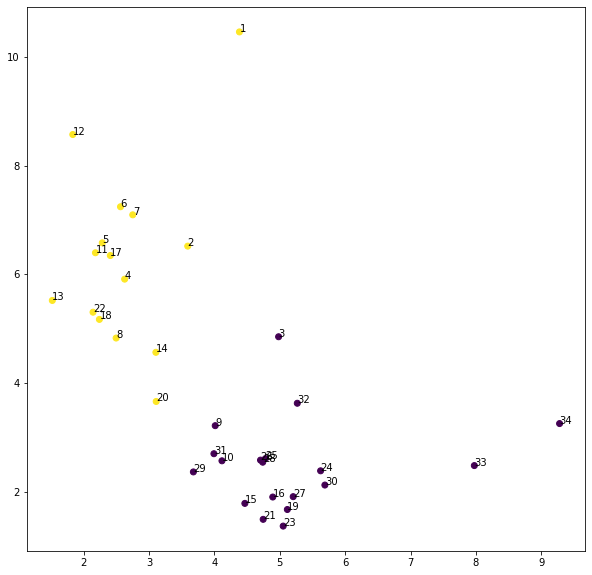

Cross Entropy Loss: = 0.002348224399611354


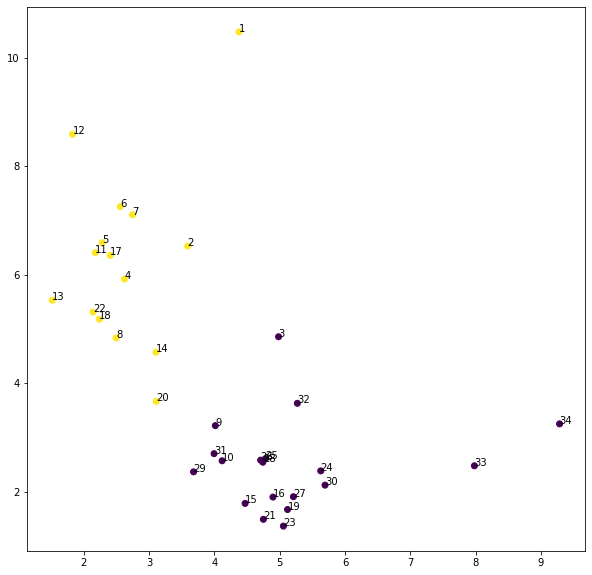

Cross Entropy Loss: = 0.0023149829357862473


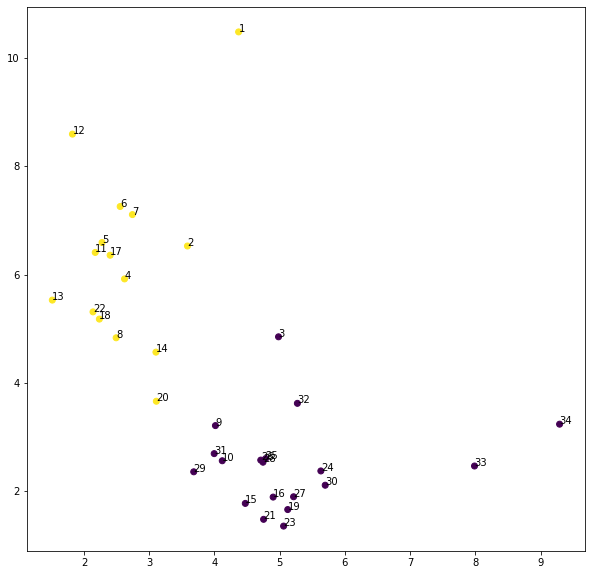

Cross Entropy Loss: = 0.0022825137712061405


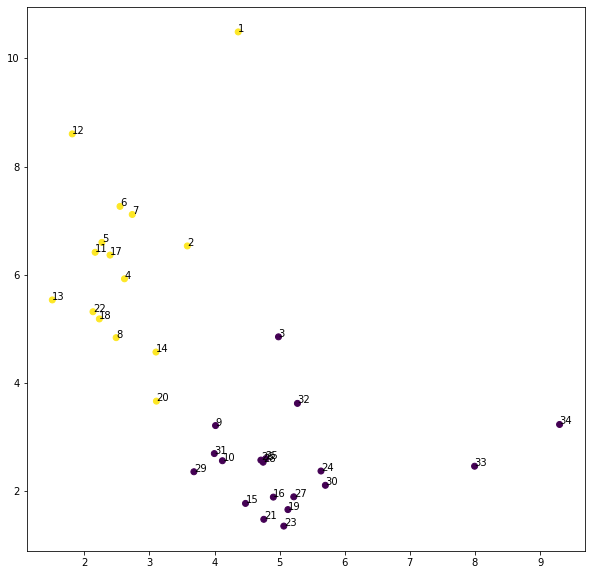

Cross Entropy Loss: = 0.0022509947884827852


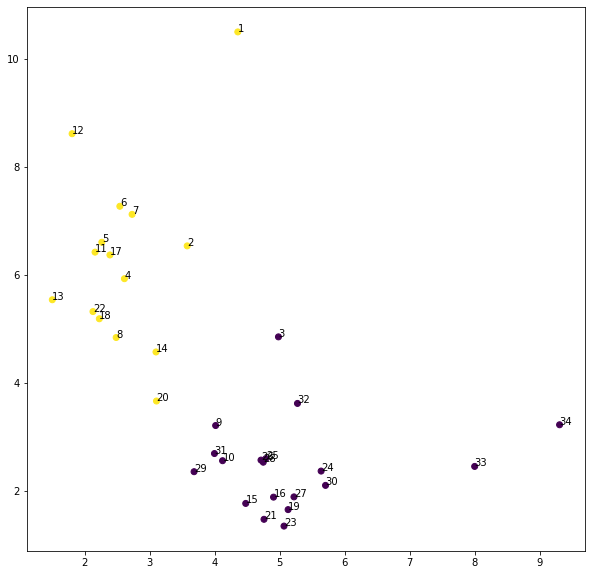

Cross Entropy Loss: = 0.0022201291285455227


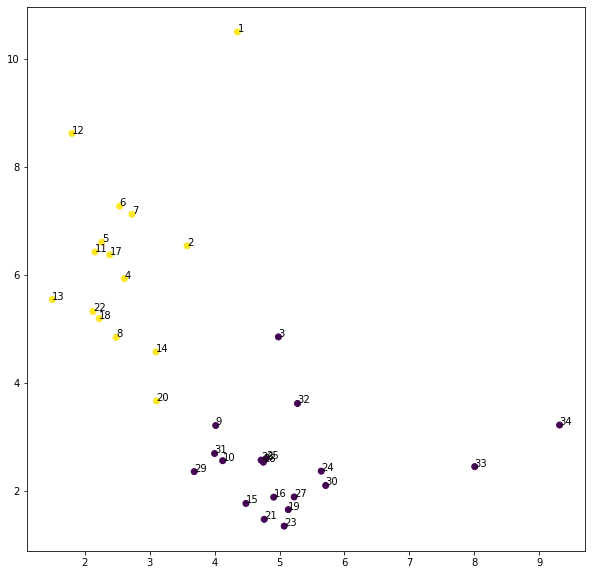

Cross Entropy Loss: = 0.0021901545114815235


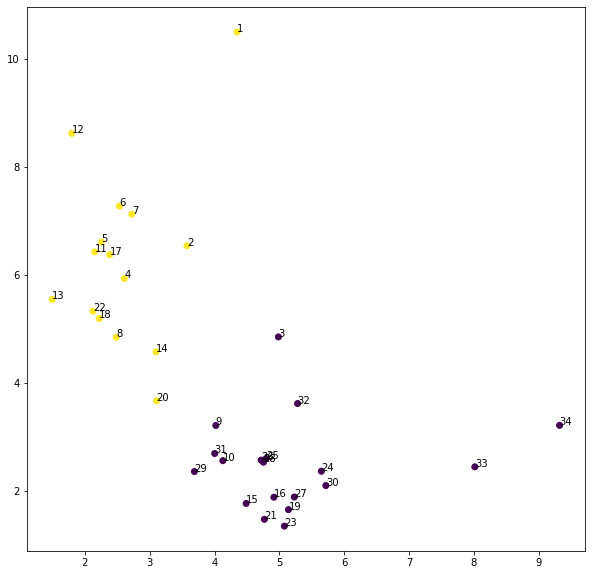

Cross Entropy Loss: = 0.0021608928218483925


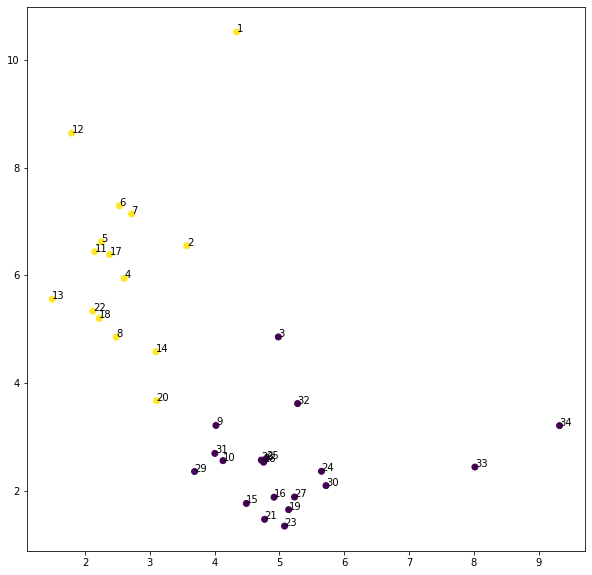

Cross Entropy Loss: = 0.0021323440596461296


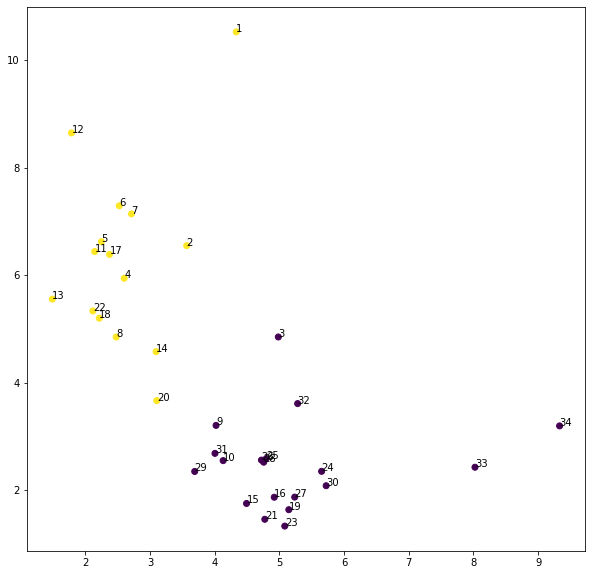

Cross Entropy Loss: = 0.002104389015585184


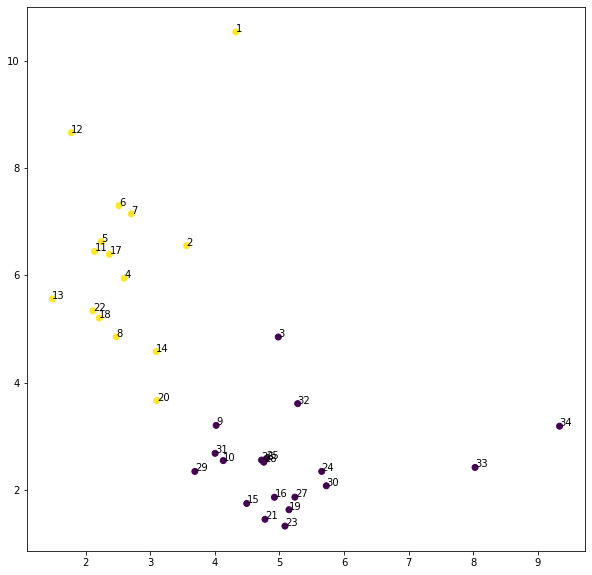

Cross Entropy Loss: = 0.0020772069692611694


In [12]:
for i in range(10000):
    optimizer.zero_grad()
    loss=criterion(T(X), target)
    loss.backward()
    optimizer.step()
    l=(T(X));
    if i%100==0:
        plt.figure(figsize=(10,10))
        plt.scatter(l.detach().numpy()[:,0],l.detach().numpy()[:,1],c=torch.argmax(l, dim=1))
        for i in range(l.shape[0]):
            plt.text(l[i,0], l[i,1], str(i+1))
        plt.show()
        print("Cross Entropy Loss: =",loss.item())

As you can see above it has divided the data in two categories , and its close to the actual predictions. __TODO__ Actual labels.